## i. BUSINESS JOB DESCRIPTION

*   Our client is an e-commerce company (_All in one Place_), a multibrand outlet. It profits comes from reseling large quantities of various products by offering low tag prices.

*   After collecting data from their clients database during the period of 1 year, the company's marketing team is analyzing wheter it would be profitable or not to separate it into distinct groups, in order to distinguish those who represent a larger ammount of the company's earnings.

*   The intended group of interest obtained from this clustering analysis will then be called 'Insiders', and will be targeted as eligible clients to win special fidelity programs opportunities.

## ii. THE CHALLENGE

*   I was hired as a Data Scientist consultant, in order to build a model capable of performing such clustering with great accuracy.

*   With the solution, the marketing team can acordingly plan how to target groups of clients in order to optimize profits.

*   In order to understand client's behaviour, we have a database containing information about sales transactions, specifying the products that were bought, their description, quantity, unit price as well as general information about client's physical location (Customer ID, country).

## iii. BUSINESS QUESTIONS

*   It is expected a report as the result of the clsutering analysis, which answers the following questions:

    1.  Which clients are eligible  to take part on the 'Insiders' group ?
    
    2.  How many clients will be selected?

    3.  What are the main features that impacts more the clustering analysis from said clients?

    4.  What is the 'Insiders' group percentage upon the company's total earnings?
    
    5.  What is the expected profit from the 'Insiders' group for the next months?

    6.  What are the main conditions that make one eligible for being on 'Insiders'?

    7.  What are the conditions for one to be excluded from 'Insiders'?

    8.  What guarantees that 'Insiders' group grants more profits to the company compared to the rest of the database?

    9.  Which actions the marketing team can partake to increase profits?


# 0.0 IMPORTS, FUNCTIONS AND DATABASE LOAD

In [232]:
!pip install inflection

In [233]:
!pip install optuna

In [234]:
!pip install ydata_profiling

In [235]:
!pip install pandasql

In [236]:
!pip install umap-learn

## 0.1 Imports

In [237]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap
import ipywidgets
import inflection
import optuna
import warnings
import os

from matplotlib         import pyplot as plt
from collections        import Counter
from ydata_profiling    import ProfileReport
from pandasql           import sqldf

from sklearn.preprocessing      import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from sklearn.mixture            import GaussianMixture
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.cluster            import KMeans, DBSCAN
from sklearn.neighbors          import NearestNeighbors
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss, silhouette_score, silhouette_samples

from scipy.cluster.hierarchy    import linkage, dendrogram, fcluster
from scipy.spatial.distance     import pdist, squareform

from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from plotly                     import express as px

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Functions

In [238]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [239]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Database load

In [240]:
df_raw = pd.read_csv('datasets/ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [241]:
#df_raw = pd.read_csv('/home/valquiriaam/repos/PA005/datasets/ecommerce.csv', encoding='unicode_escape')
#df_raw.head()

In [242]:

df1 = df_raw.copy()
df1 = df1.drop(columns=['Unnamed: 8'])

In [243]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


# 1.0 DATA DESCRIPTION

### 1.3.1 General Description

In [244]:
#df1_profile = ProfileReport(df1, title='Profile Report')
#df1_profile

In [245]:
#df1_profile.to_file('raw_dataset_profile.html')

### 1.3.2 Data Typification

*   InvoiceNo: Unique Transaction ID

*   StockCode: Item's ID code

*   Description: Item's name

*   Quantity: Quantity of product bought

*   InvoiceDate: Transaction's occurance date

*   UnitPrice:  Product's price per unit

*   CustomerID: Customer's ID code

*   Country: Customer's Country

In [246]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [247]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [248]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### 1.3.3 Missing Data Treatment

In [249]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [250]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_complete = df1.loc[~df1['customer_id'].isna(), :]

df_complete.loc[df_complete['invoice_no'].isin(df_missing['invoice_no']), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


*   No Matches for invoice_no entries for rows with customer_id = NaN.

In [251]:
df_complete['customer_id'].max()

18287.0

*   Customer_id NaN values will be filled with values 19000 onwards, in order to maintain data information on our model.

In [252]:
#Customer_id labeling
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1 )

#merge into main dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

#coalesce - combine first
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [253]:
df1['customer_id'] = df1['customer_id'].astype(int64)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [254]:
df1.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   country       541909 non-null  object        
 7   customer_id   541909 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 33.1+ MB


In [255]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 541909
Number of Columns: 8


### 1.3.4 Numerical and Categorical Data Description

In [256]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [257]:
#invoice number -> Distinct Categorical entries
invoiceno_strings = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),'invoice_no'])
negative_quantities = len(num_attributes[num_attributes['quantity'] < 0])
print(f'Count of Distinct invoice_no strings: {invoiceno_strings} \n' +
      f'Count of entries with negative quantities: {negative_quantities}')

Count of Distinct invoice_no strings: 9291 
Count of entries with negative quantities: 10624


In [258]:
df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']< 0) &
        (df1['invoice_no'].apply(lambda x: bool(re.search('^[0-9]+', x)))), :].shape[0]

1336

*   The Last output shows that we now have numerical 'invoice_no' rows containing negative quantities.

In [259]:
#After customer_id fill na
new_invoice_str = df1.loc[(df1['customer_id'] > 19000) &
                          (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :].shape[0]
new_invoice_negative = df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']< 0) &
                          (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :].shape[0]

print(f'Total invoice_no string rows: {new_invoice_str} \n' +
      f'Total negative quantity rows: {new_invoice_negative}')

Total invoice_no string rows: 386 
Total negative quantity rows: 383


In [260]:
df1.loc[(df1['customer_id'] > 19000) & (df1['quantity']>0) &
        (df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x)))), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


*   After customer_id fill na, rows with invoice_no following the pattern Cxxxxxx still have negative quantities, thus reaffirming its 'retuned/canceled' entries status.
*   The few remaining entries fors rows with invoice_no containing string values will be removed, as the last output shows that they do not represent any item purchase.

In [261]:
#stock_code -> List of Selected Categorical Entries to further examine
at_least_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
print(f'Total Number of stock codes containing letters: {at_least_one_string}')

cat_stock = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
print(f'Total Number of string stock_codes : {len(cat_stock)}; Unique Stock Codes:{cat_stock}')

Total Number of stock codes containing letters: 54873
Total Number of string stock_codes : 12; Unique Stock Codes:['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [262]:
df_cat = df1[df1['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE',
                                     'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B',
                                     'CRUK'])]
df_cat.shape

(2759, 8)

In [263]:
#country
cat_attributes['country'].unique()



array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

Upon Analyzing Pandas profiling:

## Numerical Data Premisses

*   Rows with 'unit_price' listed as a negative value (-11062,06) will be deleted. (Not a sale entry, it is descripted as a bad debt adjust)
*   Rows with 'unit_price' listed as 0 (values between 0.0 and 0.01) will be deleted.
*   Rows with quantity listed as negative values are always corrective entries from its previous ones (returned, cancelled entries), and its invoice_number always follows the pattern Cxxxxxx.

#Categorical Data Premises

*   Rows with 'invoice_no' containing any letter (mainly folowing the pattern Cxxxxxx), will be separated as 'return dataset'; This will contain only data from cancelled/returned entries.
*   Rows with Stock Codes that only contains letters (['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']) will be deleted given that they do not represent a selling transaction.
*   Rows with country listed as ([['Unspecified', 'European Community']) will be removed.


# 2.0 DATA FILTERING

In [264]:
df2 = df1.copy()

In [265]:
#customer_id outlier removal
df2 = df2.loc[~df2['customer_id'].isin([16446])]

# unit_price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code != ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE',
                                       'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B',
                                       'CRUK'])]

#description
df2 = df2.drop(columns='description', axis=1)

# country != ['Unspecified', 'European Community']
df2 = df2.loc[~df2['country'].isin(['Unspecified', 'European Community'])]

#Quantity: Negative products means product returns; sale cancelled
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0 FEATURE ENGINEERING





In [266]:
df3 = df2.copy()

In [267]:
#data_reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

In [268]:
## Posíveis Idéias de Features:
# Moving Avg -> 7d, 14d, 31d
# Quantidade de Compras por mês -> Antes do dia 15; depois do dia 15

## 3.1 Gross Revenue

In [269]:
#Gross Revenue
df2_purchases['revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']
df_monetary = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

## 3.2 Recency

*   Reference point adopted as the most recent date on dataset ('2017-12-07').

In [270]:
#Recency -> Reference point adopted as the newest data on dataset ('2017-12-07')
df2_purchases['recency'] = df3['invoice_date'].max() - df2_purchases['invoice_date']
df2_purchases['recency'] = df2_purchases['recency'].dt.days
df_recency = df2_purchases[['customer_id', 'recency']].groupby('customer_id').min('recency').reset_index()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

## 3.3 Average Recency Days

In [271]:
#Average Recency Days
df2_freq = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])
df2_freq['previous_customer'] = df2_freq['customer_id'].shift()
df2_freq['previous_date'] = df2_freq['invoice_date'].shift()

df2_freq['avg_recency_days'] = df2_freq.apply( lambda x: (x['invoice_date'] - x['previous_date'] ).days if
                                                          x['customer_id'] == x['previous_customer'] else np.nan, axis=1)

df2_freq = df2_freq.drop( ['invoice_date', 'previous_customer', 'previous_date'], axis=1).dropna()

#average Recency
df_avg_recency_days = df2_freq.groupby('customer_id').mean().reset_index()

#merge
df_ref = pd.merge (df_ref, df_avg_recency_days, on='customer_id', how='left')

## 3.4 Total Products

In [272]:
#Total Products Bought per customer
df_products = df2_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_products = df_products.rename(columns={'quantity': 'total_products'})
df_ref = pd.merge(df_ref, df_products, on='customer_id', how='left')

## 3.5 Distinct Products per Customer


In [273]:
#Total number of distinct products (stock_code) per customer
df_stock = df2_purchases[['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_stock = df_stock.rename(columns={'stock_code': 'distinct_stock_code'})
df_ref = pd.merge(df_ref, df_stock, on='customer_id', how='left')

## 3.6 Total Purchases

In [274]:
#Total number of purchases (invoice_no) per customer
df_purchases = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_purchases = df_purchases.rename(columns={'invoice_no': 'total_purchases'})
df_ref = pd.merge(df_ref, df_purchases, on='customer_id', how='left')

## 3.7 Average Basket Size

In [275]:
#Basket Size: Average number of total products(quantity) per purchase(invoice_no)
df_basket = df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).sum().reset_index()
df_basket = df_basket[['customer_id', 'quantity']].groupby('customer_id').mean().reset_index()
df_basket = df_basket.rename(columns={'quantity': 'basket_size'})
df_ref = pd.merge(df_ref, df_basket, on='customer_id', how='left')

## 3.8 Average Unique Basket Size

In [276]:
# Unique Basket Size: Average number of total distinct products (stock_code) per purchase(invoice_no)
df_unique_basket = df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby(['customer_id', 'invoice_no']).count().reset_index()
df_unique_basket = df_unique_basket[['customer_id', 'stock_code']].groupby('customer_id').mean().reset_index()
df_unique_basket = df_unique_basket.rename(columns={'stock_code': 'unique_basket_size'})
df_ref = pd.merge(df_ref, df_unique_basket, on='customer_id', how='left')

## 3.9 Average Ticket

In [277]:
#Avg Ticket per client
df_ticket = df2_purchases[['customer_id', 'revenue']].groupby(['customer_id']).mean().reset_index()
df_ticket = df_ticket.rename(columns={'revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')

## 3.10 Frequency

In [278]:
df_freq = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                       .groupby('customer_id')
                                                                       .agg( max_ = ( 'invoice_date', 'max'),
                                                                             min_ = ( 'invoice_date', 'min'),
                                                                             days_ = ( 'invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                             buy_ = ('invoice_no', 'count'))).reset_index()

#Frequency
df_freq['frequency'] = df_freq[['buy_', 'days_']].apply( lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

#Merge
df_ref = pd.merge(df_ref, df_freq[['customer_id', 'frequency']], on='customer_id', how='left')

## 3.11 Total Returned Products

In [279]:
df_returned = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'returned'})
df_returned['returned'] = df_returned['returned'] * (-1)

df_ref = pd.merge(df_ref, df_returned, on='customer_id', how='left')
df_ref.loc[df_ref['returned'].isna(), 'returned'] = 0

In [280]:
df_ref.isna().sum()

customer_id               0
revenue                  91
recency                  91
avg_recency_days       3013
total_products           91
distinct_stock_code      91
total_purchases          91
basket_size              91
unique_basket_size       91
avg_ticket               91
frequency                91
returned                  0
dtype: int64

In [281]:
df_ref.head()

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
0,17850,5391.21,372.0,1.000000,1733.0,21.0,34.0,50.970588,8.735294,18.152222,17.000000,40.0
1,13047,3232.59,56.0,52.833333,1390.0,105.0,9.0,154.444444,19.000000,18.904035,0.028302,35.0
2,12583,6705.38,2.0,26.500000,5028.0,114.0,15.0,335.200000,15.466667,28.902500,0.040323,50.0
3,13748,948.25,95.0,92.666667,439.0,24.0,5.0,87.800000,5.600000,33.866071,0.017921,0.0
4,15100,876.00,333.0,20.000000,80.0,1.0,3.0,26.666667,1.000000,292.000000,0.073171,22.0


#   4.0 EDA (EXPLORATORY DATA ANALYSIS)

*   The goal here is to look after features that introduces great variability to our model, in order to obtain **condensed and distant** clusters.

*   Central tendency Metrics : Mean, Median
    *   Look after values that are too far from the central tendency (Outliers)
*   Dispersion Metrics: Min & Max values (range), Standard Deviation, Variance (std / Nº of examples), Variance Coef (CV)(std/mean)
    *   Generally, features with high variance are wanted in our model.
    *   Wide range features tend to offer more variability to our model.
*   Variable Distribution




In [282]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id            0
revenue                0
recency                0
avg_recency_days       0
total_products         0
distinct_stock_code    0
total_purchases        0
basket_size            0
unique_basket_size     0
avg_ticket             0
frequency              0
returned               0
dtype: int64

In [283]:
#eda_profile = ProfileReport(df4, title='EDA Profile')
#eda_profile

In [284]:
#eda_profile.to_file('eda_profile_ver2.html')

Upon Pandas profiling EDA analysis:

*   Revenue: High Variability
*   Recency: Low Variability
*   Average Recency Days: Low Variability
*   Total Number of Products: High Variability
*   Total Number of Distinct products: Low Variability
*   Total Number of Purchases: High Variability
*   Basket Size (Total products per Purchase): High Variability
*   Unique basket Size (Total number of distinct products per Purchase): Low Variability
*   Average Ticket: High Variability
*   Total of Products Returned: High Variability

## 4.1 Univariative Analysis

### 4.1.1 Revenue

In [285]:
df4[df4['revenue'].isin([279138.02, 259657.3, 194550.79, 168472.5, 140438.72])].sort_values('revenue', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
1017,14646,279138.02,1.0,8.022727,196844.0,699.0,72.0,2733.944444,28.611111,135.503893,0.203390,288.0
492,18102,259657.30,0.0,14.680000,64124.0,150.0,60.0,1068.733333,7.183333,602.453132,0.163043,0.0
433,17450,194550.79,8.0,13.807692,69993.0,124.0,46.0,1521.586957,7.326087,577.302047,0.127778,952.0
66,14911,140438.72,1.0,2.861538,79963.0,1785.0,199.0,401.824121,28.492462,24.768734,0.533512,3332.0


In [286]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending=False).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646


In [287]:
df3[df3['customer_id'] == 16446].sort_values('quantity', ascending=False).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.2 Total Number of Products

In [288]:
df4[df4['total_products'].isin([196844, 80997, 79963])].sort_values('total_products', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
1017,14646,279138.02,1.0,8.022727,196844.0,699.0,72.0,2733.944444,28.611111,135.503893,0.203390,288.0
66,14911,140438.72,1.0,2.861538,79963.0,1785.0,199.0,401.824121,28.492462,24.768734,0.533512,3332.0


### 4.1.3 Total Number of Purchases

In [289]:
df4[df4['total_purchases'].isin([206, 199, 124])].sort_values('total_purchases', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
47,12748,32305.32,0.0,3.330357,25211.0,1765.0,206.0,122.383495,22.218447,7.058187,0.550802,1535.0
66,14911,140438.72,1.0,2.861538,79963.0,1785.0,199.0,401.824121,28.492462,24.768734,0.533512,3332.0
68,17841,40959.72,1.0,3.351351,22853.0,1321.0,124.0,184.298387,63.201613,5.226454,0.332440,203.0


### 4.1.4 Basket Size (Total Number of Products per Purchase)

In [290]:
df4[df4['basket_size'].isin([40498.5, 3868.65])].sort_values('basket_size', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
1150,12415,124564.53,24.0,22.357143,77373.0,443.0,20.0,3868.65,35.65,174.704811,0.063694,427.0


### 4.1.5 Average Ticket

In [291]:
df4[df4['avg_ticket'].isin([56157.5, 4453.43])]

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
1262,15749,44534.3,235.0,97.0,18028.0,5.0,3.0,6009.333333,3.333333,4453.43,0.030612,9014.0


### 4.1.6 Frequency

In [292]:
df4[df4['frequency'].isin([17, 3, 2])].sort_values('frequency', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
0,17850,5391.21,372.0,1.0,1733.0,21.0,34.0,50.970588,8.735294,18.152222,17.0,40.0
5576,18139,8438.34,17.0,1.0,5557.0,35.0,6.0,926.166667,26.500000,53.071321,3.0,0.0
5695,15060,301.84,8.0,1.0,262.0,80.0,4.0,65.500000,30.000000,2.515333,2.0,0.0


In [293]:
df_freq[df_freq['customer_id'] == 17850]

,customer_id,max_,min_,days_,buy_,frequency
4007,17850,2016-11-30,2016-11-29,2,34,17.0


In [294]:
df_freq[df_freq['customer_id'] == 18139]

,customer_id,max_,min_,days_,buy_,frequency
4219,18139,2017-11-20,2017-11-19,2,6,3.0


In [295]:
df4[df4['frequency'] == 0.005449591280653951]

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
64,14594,379.83,7.0,366.0,185.0,48.0,2.0,92.5,26.5,7.166604,0.00545,0.0


In [296]:
df_freq[df_freq['customer_id'] == 14594]

,customer_id,max_,min_,days_,buy_,frequency
1651,14594,2017-11-30,2016-11-29,367,2,0.00545


### 4.1.7 Returned

In [297]:
df4[df4['returned'].isin([80995	, 9014, 8004])].sort_values('returned', ascending=False)

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
1262,15749,44534.30,235.0,97.000000,18028.0,5.0,3.0,6009.333333,3.333333,4453.430000,0.030612,9014.0
12,16029,72882.09,38.0,9.054054,40207.0,43.0,62.0,648.500000,3.887097,302.415311,0.184524,8004.0


In [298]:
df3[df3['customer_id'] == 15749].sort_values('quantity', ascending=False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52711,540815,21108,3114,2017-01-09,2.10,United Kingdom,15749
160546,550461,21108,3114,2017-04-16,2.10,United Kingdom,15749
52710,540815,21175,2000,2017-01-09,1.85,United Kingdom,15749
160545,550461,21175,2000,2017-04-16,1.69,United Kingdom,15749
52709,540815,85123A,1930,2017-01-09,2.55,United Kingdom,15749
160542,550461,85123A,1930,2017-04-16,2.40,United Kingdom,15749
52771,540818,47556B,1300,2017-01-09,2.55,United Kingdom,15749
160543,550461,47556B,1300,2017-04-16,2.10,United Kingdom,15749
52772,540818,48185,670,2017-01-09,6.75,United Kingdom,15749
160544,550461,48185,670,2017-04-16,6.35,United Kingdom,15749


In [299]:
df3[df3['customer_id'] == 16029].sort_values('quantity', ascending=False).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
32671,539101,22693,2400,2016-12-14,0.94,United Kingdom,16029
87631,543669,22693,2400,2017-02-09,0.94,United Kingdom,16029
383960,570094,20971,1296,2017-10-05,1.06,United Kingdom,16029
384010,570097,20971,1296,2017-10-05,1.06,United Kingdom,16029
390552,570557,20971,1296,2017-10-09,1.06,United Kingdom,16029


In [300]:
df3[df3['customer_id'] == 16029].sort_values('quantity', ascending=False).tail()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
390541,C570556,22273,-720,2017-10-09,2.30,United Kingdom,16029
390547,C570556,22273,-720,2017-10-09,2.55,United Kingdom,16029
390543,C570556,22147,-840,2017-10-09,1.25,United Kingdom,16029
390548,C570556,20971,-1296,2017-10-09,1.06,United Kingdom,16029
390544,C570556,20971,-1296,2017-10-09,1.06,United Kingdom,16029


### 4.1.8 Univariative Conclusions

*   From the Information gathered analysing the main outliers on features with high variability (High value for Coeficient of Variation), we could visualize that some of theses purchases have a canceled entry counterpart.
*   The outliers do not represent fraud by looking on their own; their values are backed up given the analysis on their granularity in the database.

## 4.2 Bivariative Analysis

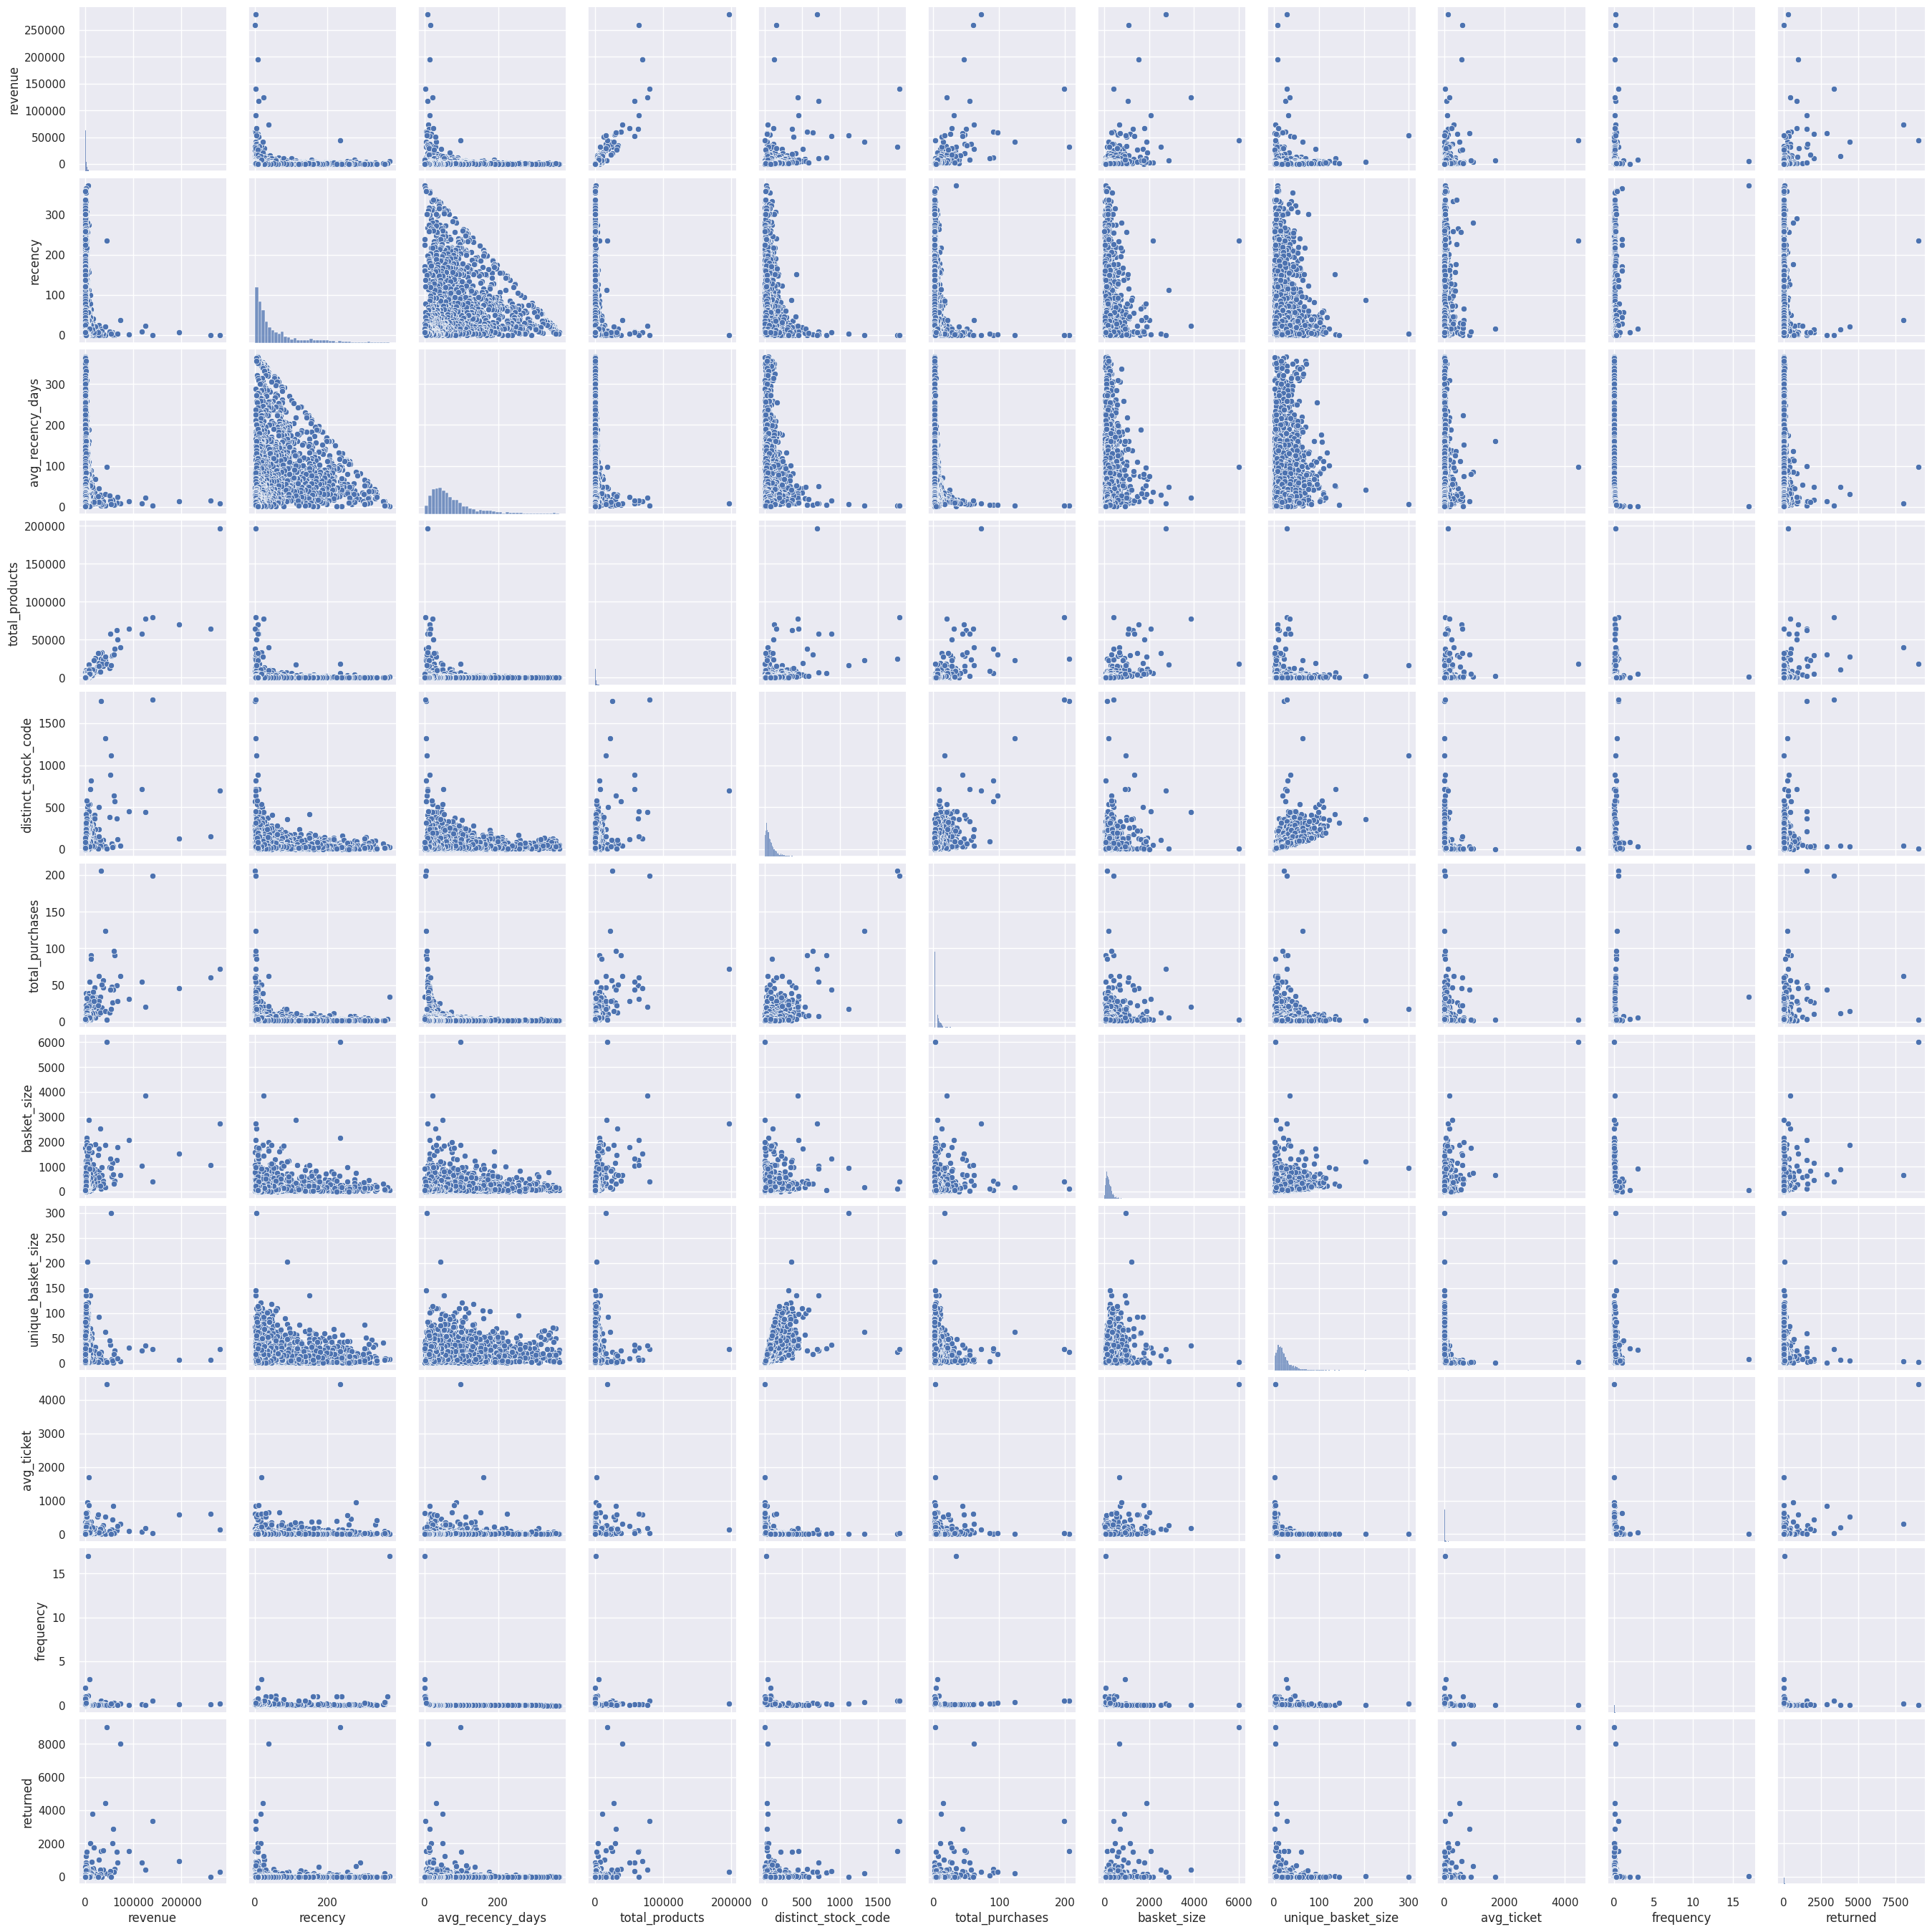

In [301]:
pairplot = df4.drop(columns=['customer_id'], axis=1)
sns.pairplot(pairplot);

Notably, some features present very similar behaviour/variability with correlated ones:

- Basket Size, Unique Basket Size, Total Purchases
- Total Purchases, Total Products, Distinct Stock Code
- Recency, Average Recency Days

Also important to note the features that present very low variability when plotted along the others:

- Frequency

# 5.0 DATA PREPARATION

In [302]:
df5 = df4.copy()

In [303]:
df5.head()

,customer_id,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
0,17850,5391.21,372.0,1.000000,1733.0,21.0,34.0,50.970588,8.735294,18.152222,17.000000,40.0
1,13047,3232.59,56.0,52.833333,1390.0,105.0,9.0,154.444444,19.000000,18.904035,0.028302,35.0
2,12583,6705.38,2.0,26.500000,5028.0,114.0,15.0,335.200000,15.466667,28.902500,0.040323,50.0
3,13748,948.25,95.0,92.666667,439.0,24.0,5.0,87.800000,5.600000,33.866071,0.017921,0.0
4,15100,876.00,333.0,20.000000,80.0,1.0,3.0,26.666667,1.000000,292.000000,0.073171,22.0


In [304]:
df5 = df5.drop( columns = ['customer_id'], axis=1)

In [305]:
df5_aux = df5.copy()

## 5.1 Numerical Values (Reescaling, Standardization)

In [306]:
##Standard Scaler
ss = StandardScaler()
rs = RobustScaler()
mms = MinMaxScaler()

df5['revenue']             = mms.fit_transform(df5[['revenue']])
df5['recency']             = mms.fit_transform(df5[['recency']])
df5['avg_recency_days']    = mms.fit_transform(df5[['avg_recency_days']])
df5['total_products']      = mms.fit_transform(df5[['total_products']])
df5['distinct_stock_code'] = mms.fit_transform(df5[['distinct_stock_code']])
df5['total_purchases']     = mms.fit_transform(df5[['total_purchases']])
df5['basket_size']         = mms.fit_transform(df5[['basket_size']])
df5['unique_basket_size']  = mms.fit_transform(df5[['unique_basket_size']])
df5['avg_ticket']          = mms.fit_transform(df5[['avg_ticket']])
df5['frequency']           = mms.fit_transform(df5[['frequency']])
df5['returned']            = mms.fit_transform(df5[['returned']])

X = df5.copy()

### 5.1.1 Individual Variable analysis/testing

In [307]:
variable = 'revenue'

Min Value:36.56 ; Max Value:279138.02


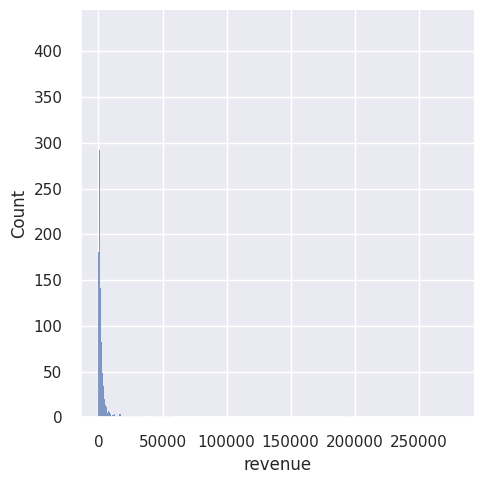

In [308]:
#@title { vertical-output: true}

#Original Data
print(f'Min Value:{df5_aux[variable].min()} ; Max Value:{df5_aux[variable].max()}')
sns.displot(df5_aux, x=variable);

Min Value:0.0 ; Max Value:0.9999999999999999


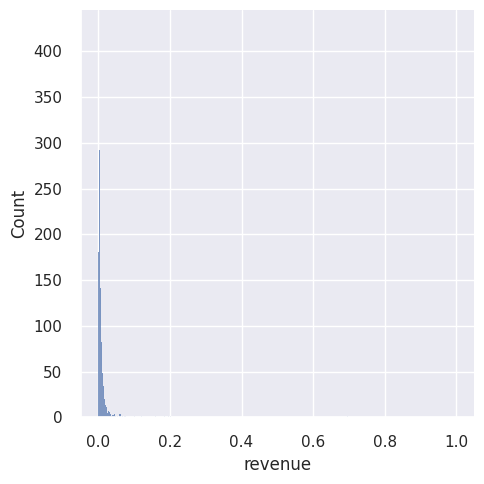

In [309]:
#@title { vertical-output: true}

#Reescaled Data
print(f'Min Value:{df5[variable].min()} ; Max Value:{df5[variable].max()}')
sns.displot(df5, x=variable)

<Axes: xlabel='revenue'>

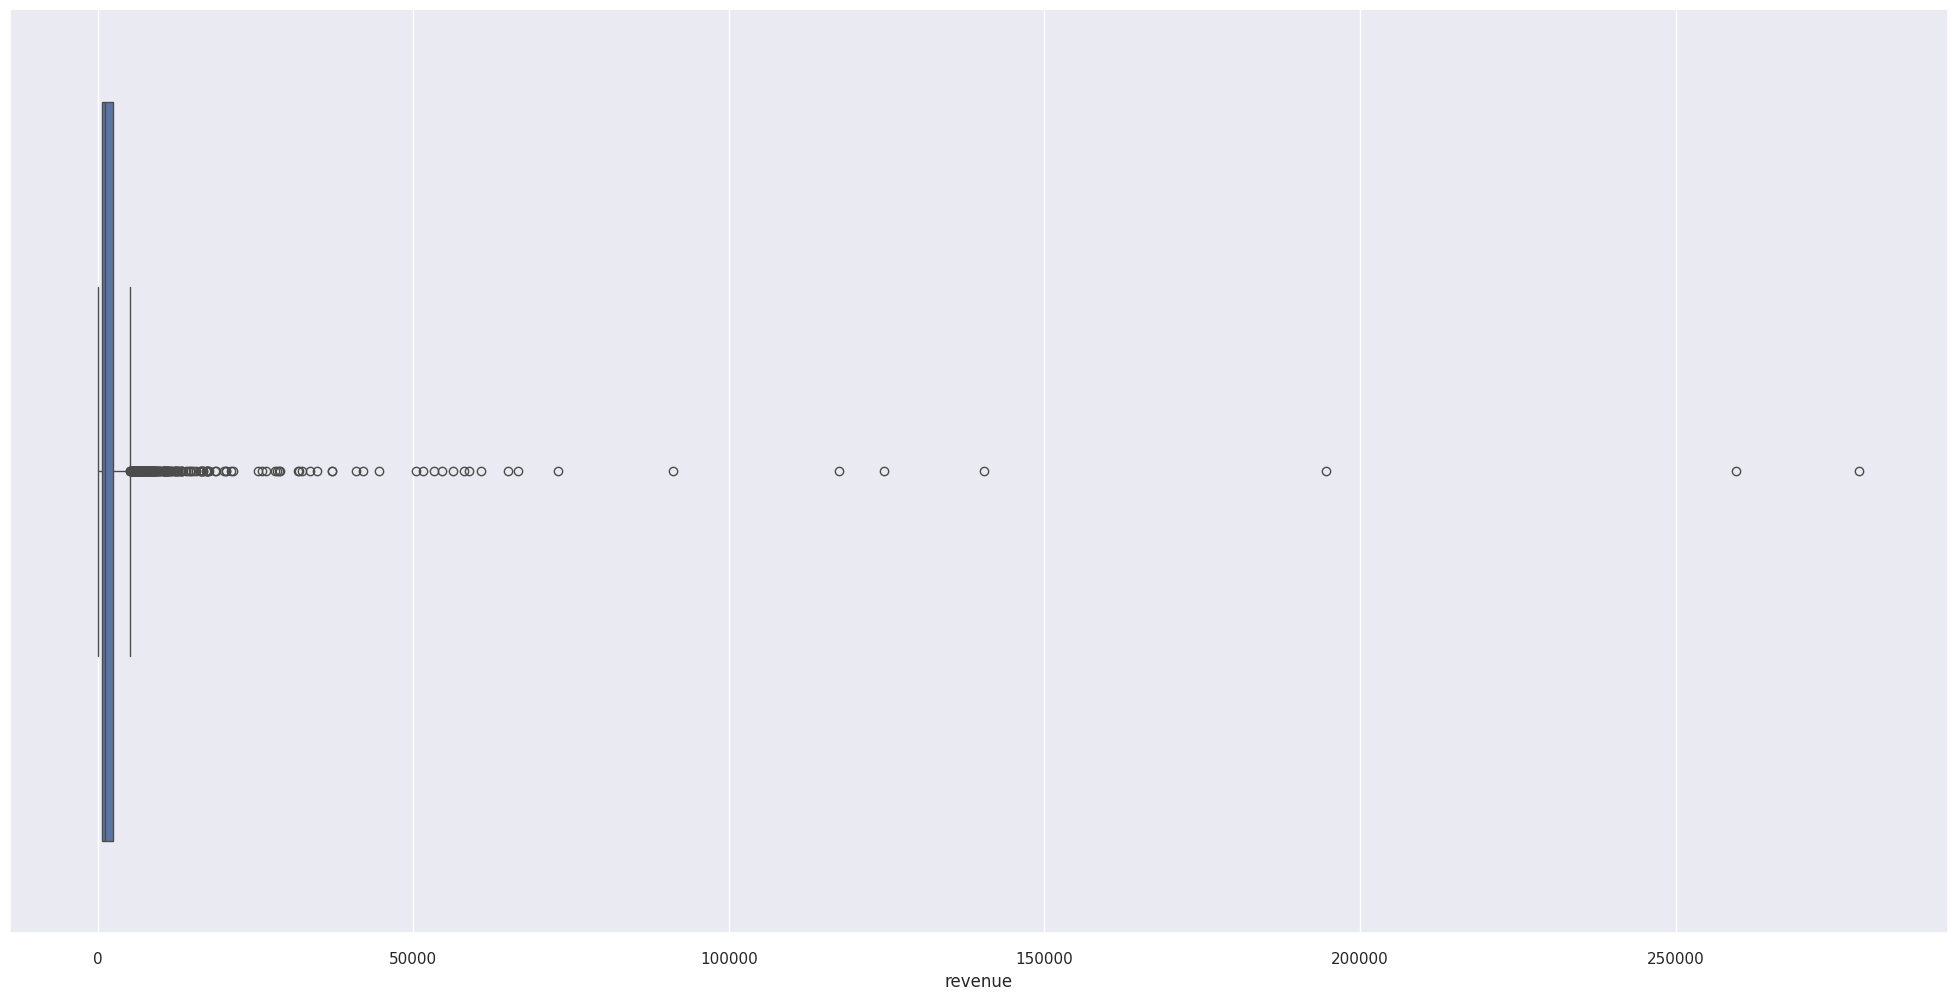

In [310]:
#@title { vertical-output: true}

#Boxplot
sns.boxplot(df5_aux, x=variable)

In [311]:
X.head()

,revenue,recency,avg_recency_days,total_products,distinct_stock_code,total_purchases,basket_size,unique_basket_size,avg_ticket,frequency,returned
0,0.019185,1.000000,0.000000,0.008794,0.011211,0.156863,0.008317,0.025896,0.003595,1.000000,0.004438
1,0.011451,0.150538,0.142009,0.007051,0.058296,0.034314,0.025539,0.060260,0.003764,0.001345,0.003883
2,0.023894,0.005376,0.069863,0.025533,0.063341,0.063725,0.055623,0.048431,0.006010,0.002052,0.005547
3,0.003267,0.255376,0.251142,0.002220,0.012892,0.014706,0.014447,0.015400,0.007125,0.000734,0.000000
4,0.003008,0.895161,0.052055,0.000396,0.000000,0.004902,0.004272,0.000000,0.065116,0.003985,0.002441


In [312]:
X.shape

(2773, 11)

## 5.2 Categorical Values (Encoding)

## 5.3 DataSpace Studying - Embedding

### 5.3.1 PCA

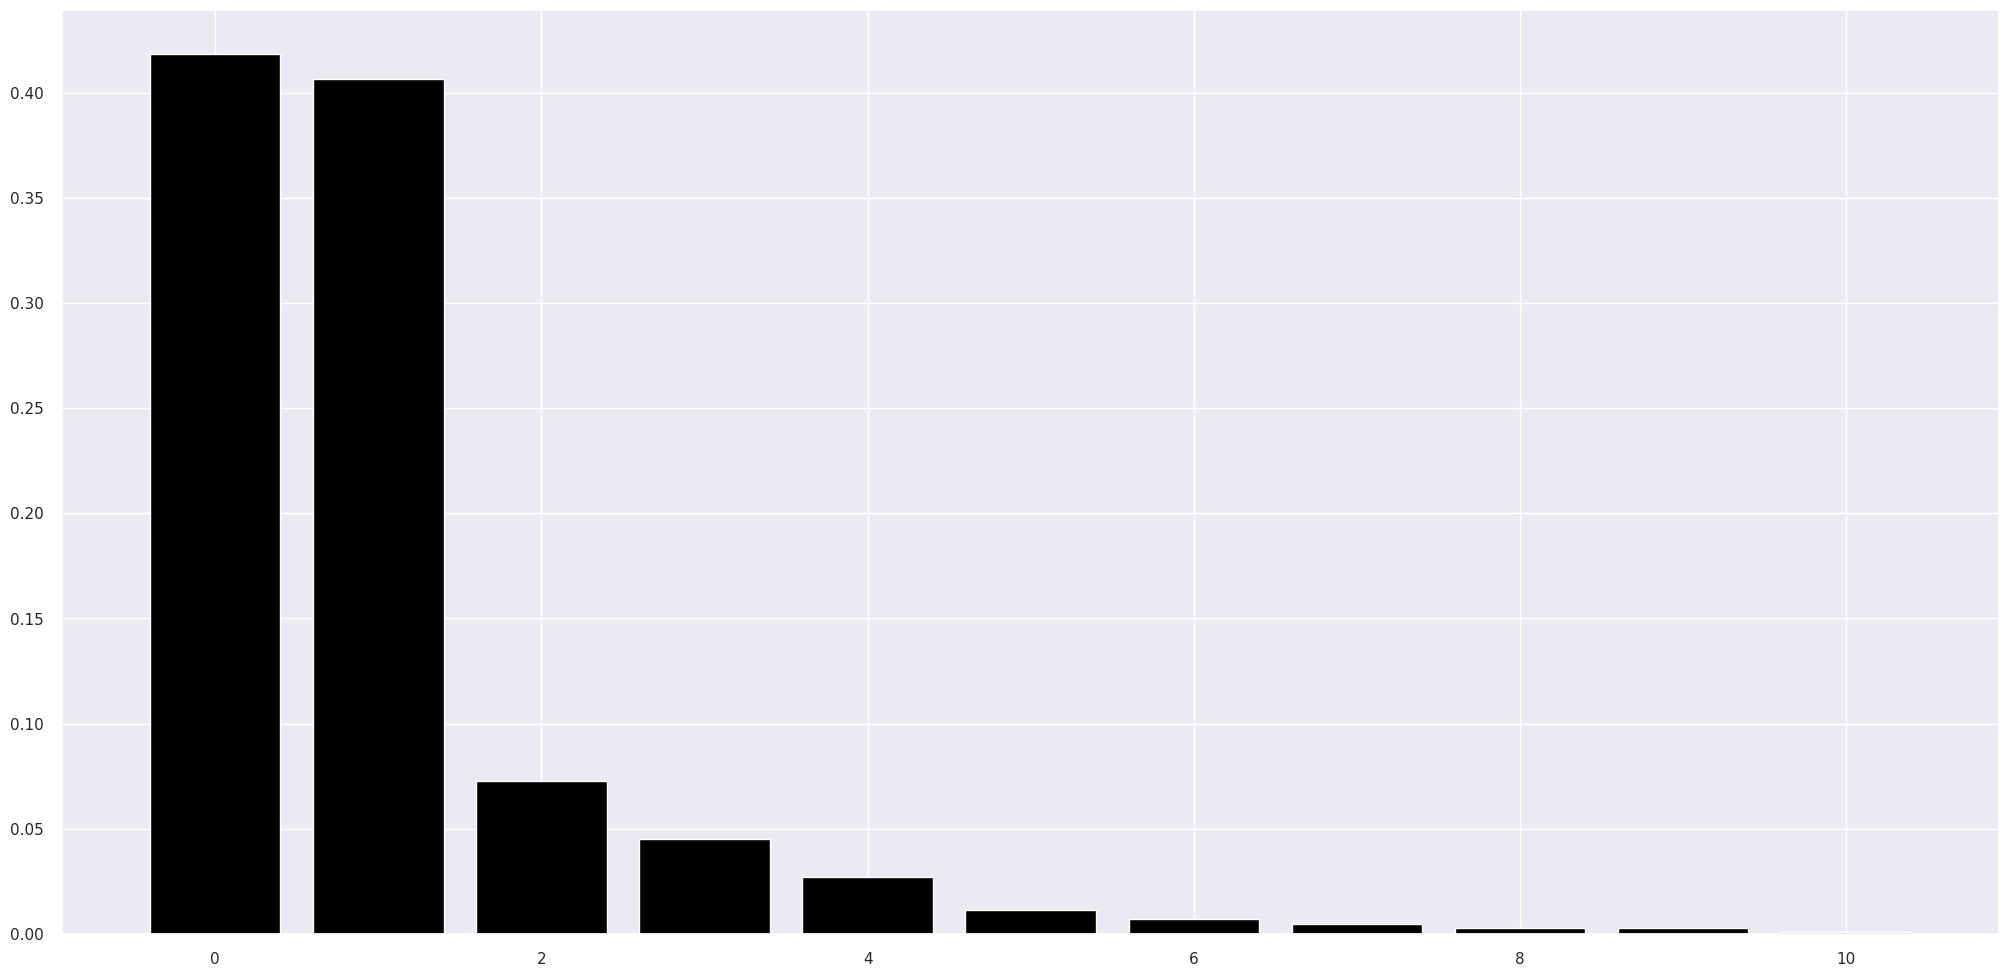

In [313]:
pca = PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform(X)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black');

In [314]:
#pca components
df_pca = pd.DataFrame( principal_components )

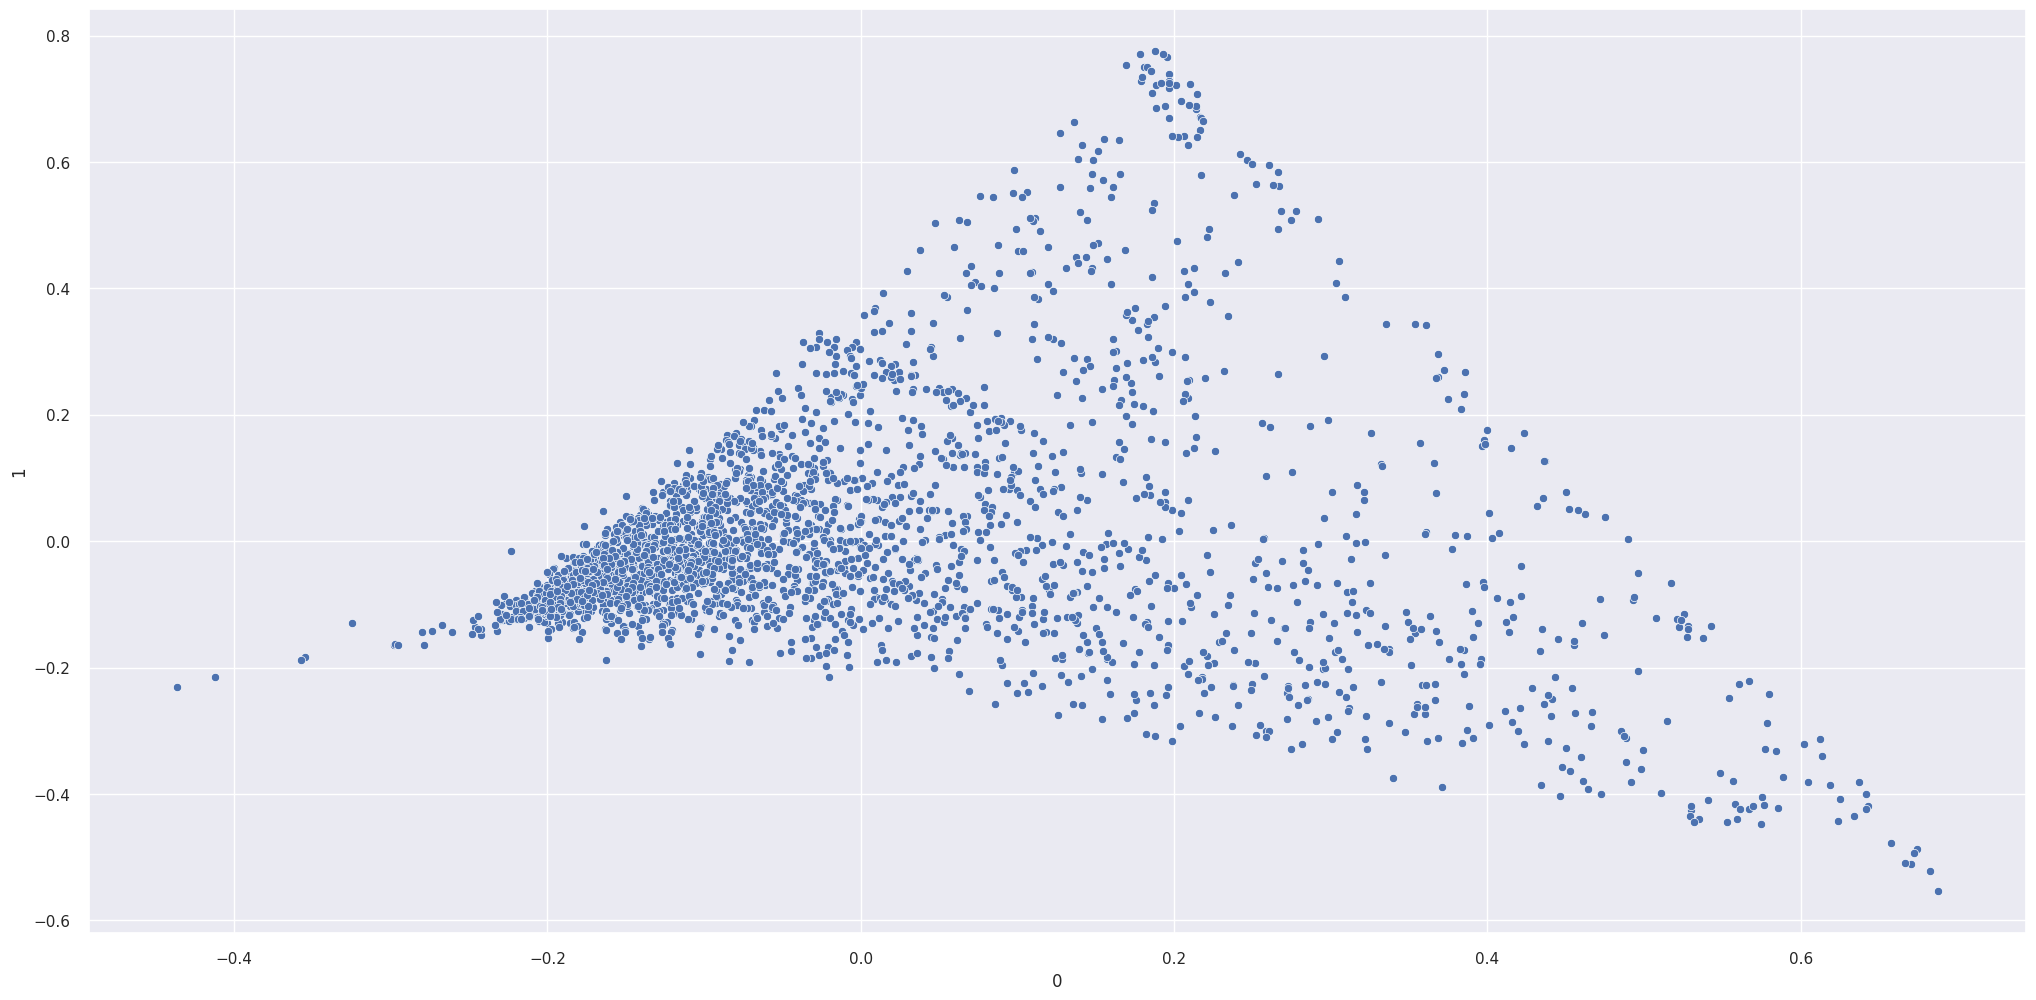

In [315]:
sns.scatterplot(x=0, y=1, data = df_pca);

### 5.3.2 UMAP

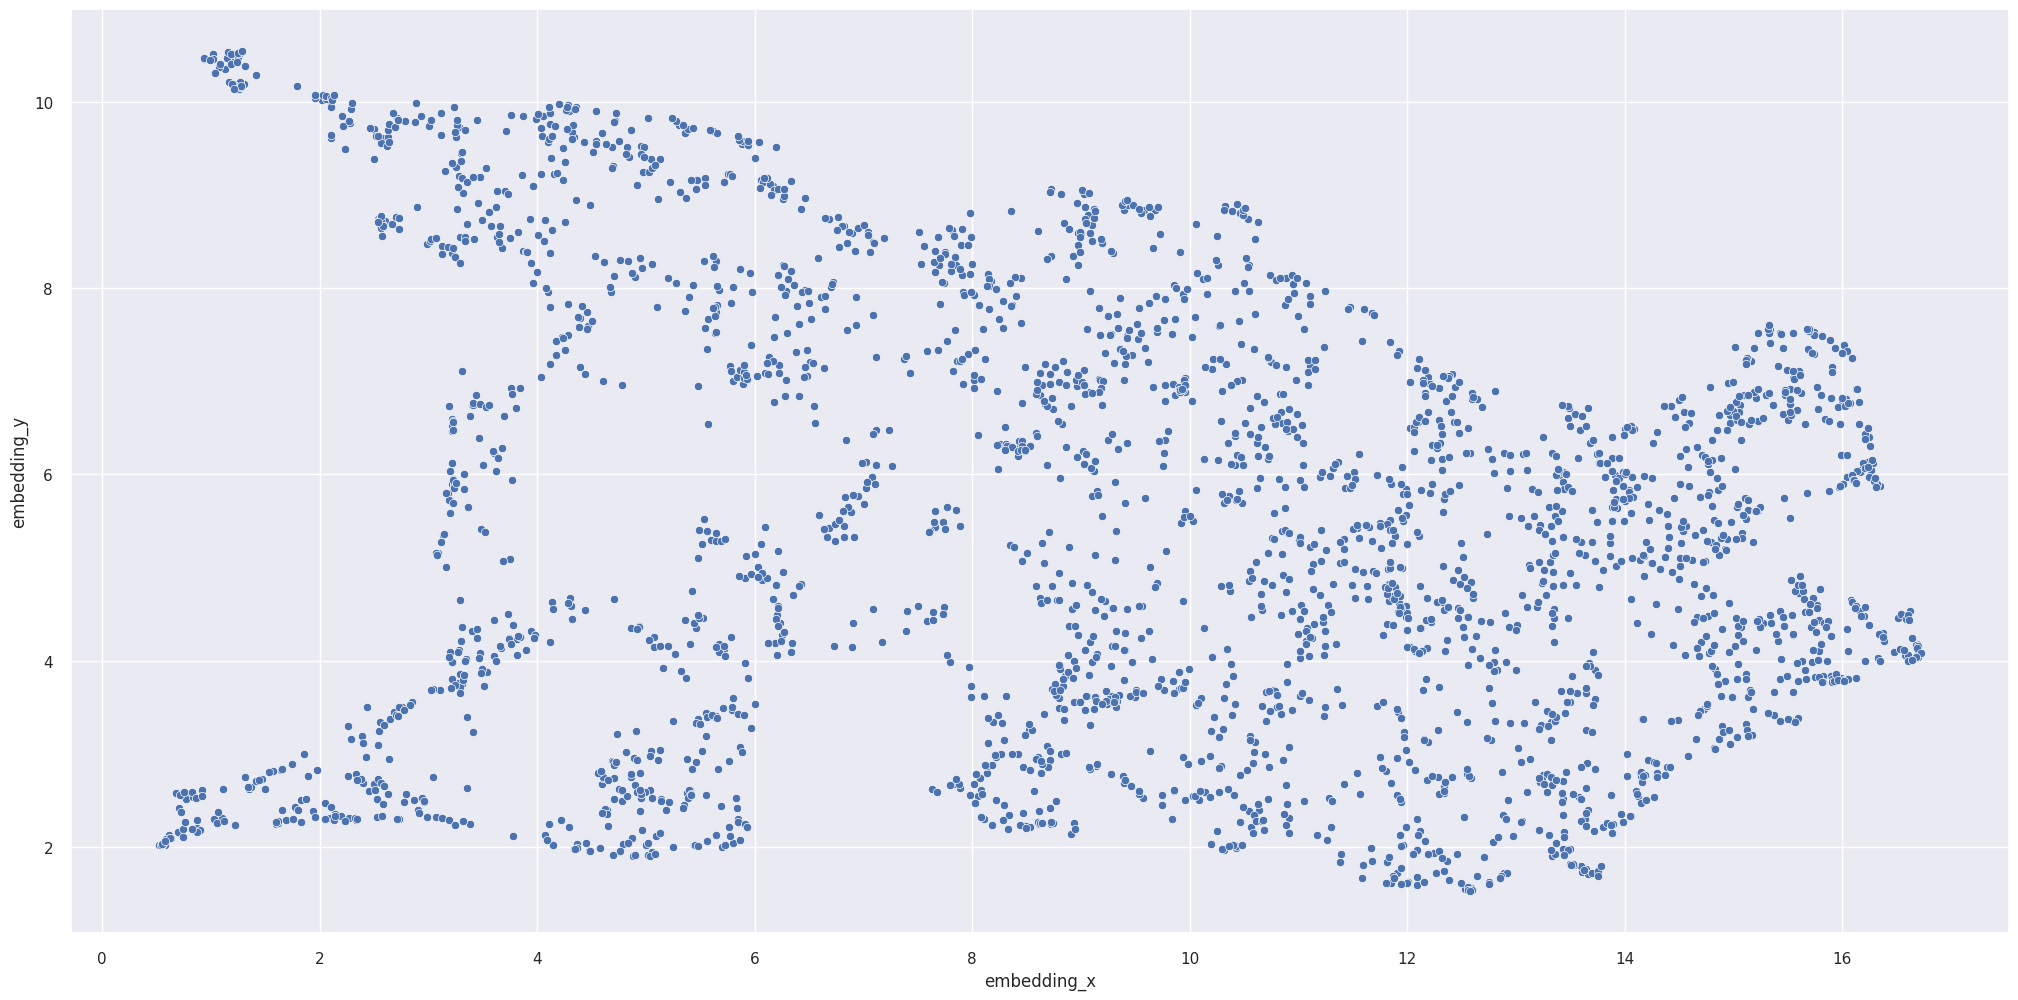

In [316]:
#@title { vertical-output: true}
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#Plot
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.3 t-SNE

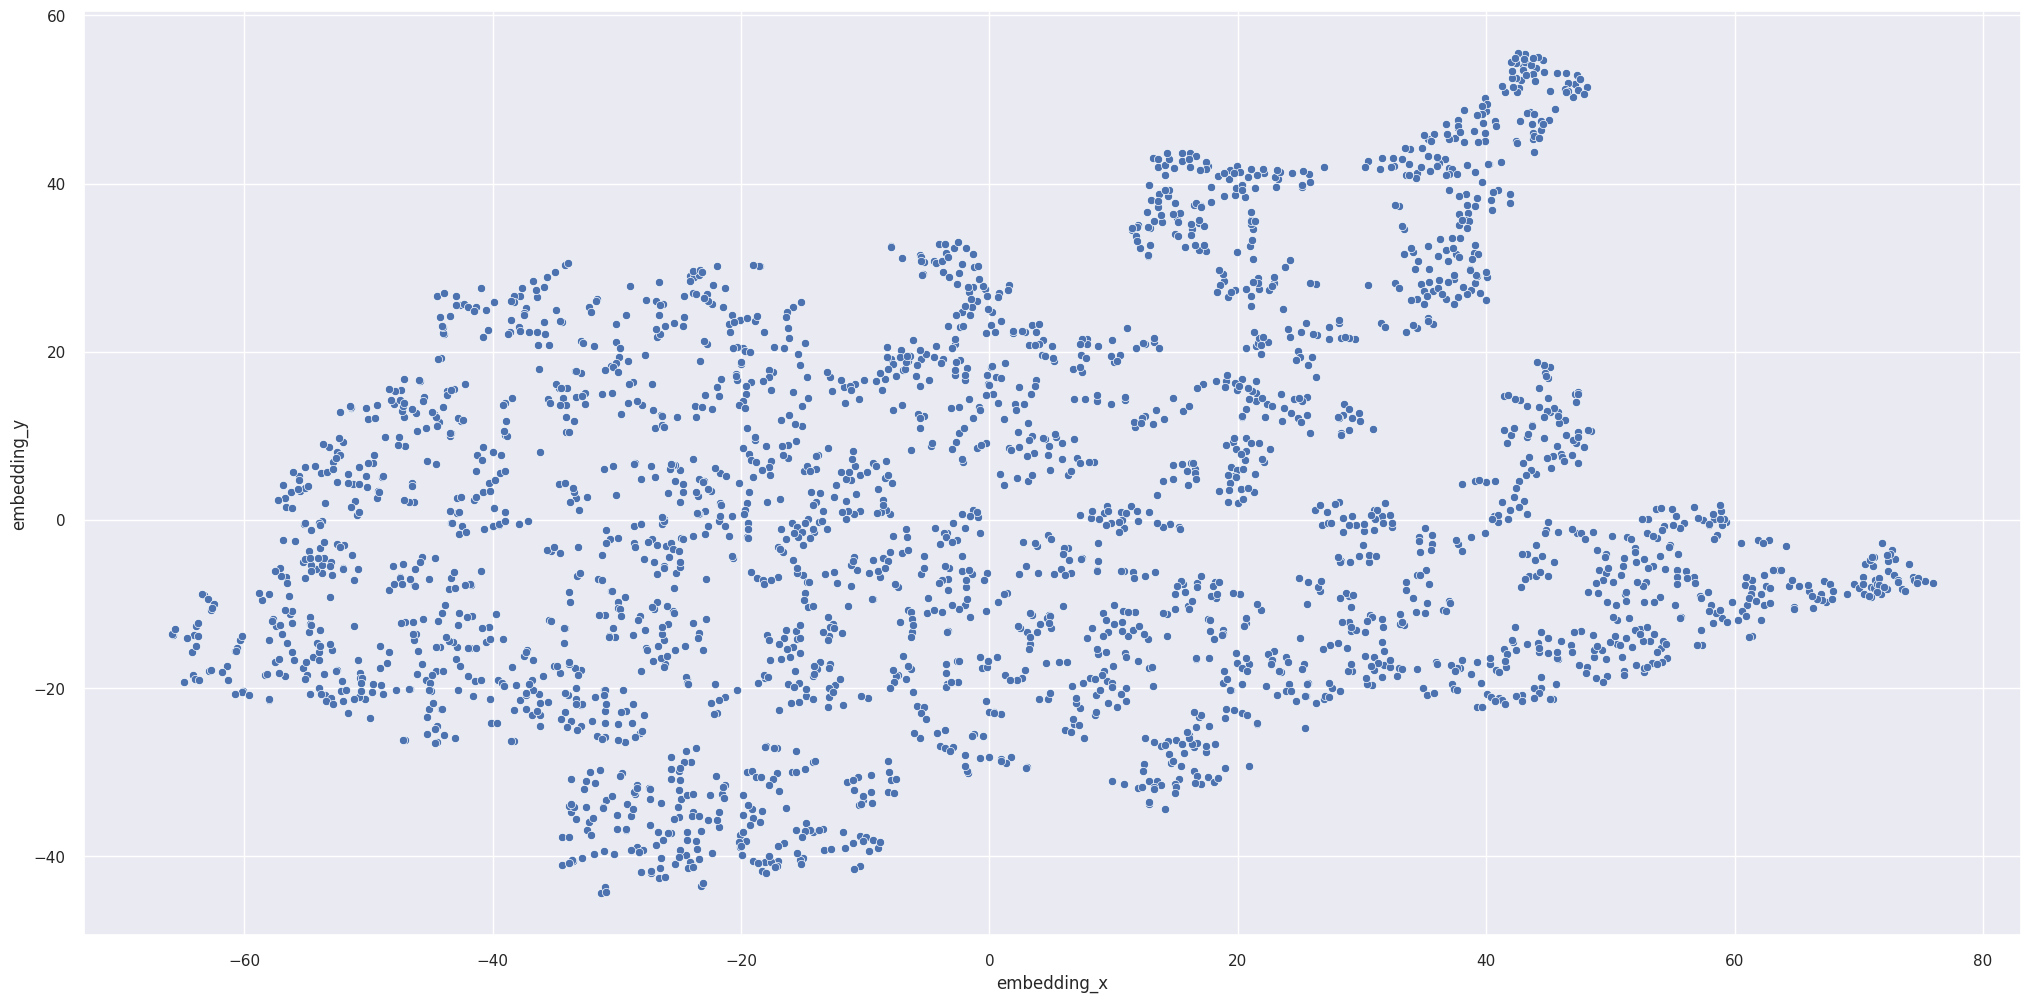

In [317]:
#@title { vertical-output: true}
reducer = TSNE( n_components = 2, n_jobs = -1,
                random_state=42 )
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#Plot
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.4 Tree-based Embedding

In [318]:
X = df4.drop(columns=['customer_id', 'revenue'], axis = 1)
y = df4[['revenue']]

In [319]:
#Model Definition
rf_model = RandomForestRegressor(n_estimators=100, random_state = 42)

#Model Training
rf_model.fit(X, y)

#Leaf

RandomForestRegressor(random_state=42)

In [320]:
df_leaf = pd.DataFrame(rf_model.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2645,2869,3092,2916,2618,2928,2900,3077,2638,3068,3104,2919,2932,2946,2475,2917,2935,2924,2984,2966,2554,2494,2817,3100,2838,3080,2973,2737,2872,3002,2886,3064,3001,2857,3029,2935,3135,2772,2692,2979,2932,2813,2896,2858,2838,2904,2887,3132,2979,2870,2568,2939,2881,3070,2896,3060,2932,2945,2823,2845,2786,3059,2835,2924,2851,2688,2759,2865,3034,2927,2550,2637,3165,2701,2864,3002,3056,2622,2991,3004,2551,2854,2842,2829,2790,3102,2890,2990,2863,2879,2702,2598,2649,2847,2733,2997,2921,2920,3030,2777
1,2530,2773,2620,2893,2171,2891,2601,2694,2508,2353,2732,2581,2855,2873,2493,2869,2824,2812,2665,2590,2895,2734,2654,2697,2688,2331,2462,2629,2844,2517,2742,2586,2676,2815,2674,2556,2839,2747,2636,2876,2606,2792,2890,2876,2820,2570,2674,2375,2598,2824,2465,2856,2739,2555,2770,2749,2904,2838,2621,2561,2623,2651,2777,2801,2648,2859,2747,2859,2607,2902,2540,2443,2806,2672,2480,2994,2702,2565,2844,2596,2833,2911,2636,2809,2714,2746,2873,2935,2832,2847,2505,2514,2665,2733,2688,2596,2844,2856,2678,2734
2,3413,3395,3308,3375,3338,3418,3246,3279,3407,3341,3404,3284,3364,3449,3343,3266,3347,3380,3372,3179,3406,3351,3292,3298,3348,3420,3285,3285,3289,3419,3323,3390,3398,3312,3362,3368,3313,3380,3330,3316,3188,3322,3340,3283,3350,3240,3274,3373,3403,3362,3367,3390,3297,3341,3410,3352,3347,3396,3301,3369,3393,3333,3285,3415,3283,3402,3386,3341,3388,3338,3243,3359,3292,3356,3378,3312,3401,3332,3467,3208,3284,3348,3376,3339,3322,3433,3382,3396,3296,3359,3327,3307,3308,3288,3304,3417,3344,3298,3304,3402
3,1615,1068,1063,1133,1823,1826,1533,1433,1259,1280,1871,1597,1769,1714,2099,1349,1969,1300,1364,1741,1849,1547,1480,1901,1642,1248,1292,1589,1342,1955,1536,1831,1264,1380,1248,1949,1669,1210,1064,1458,1136,1190,1518,1459,1588,1231,1593,1185,1589,1097,1593,1350,1301,1685,1658,1219,1818,1610,1302,1288,1290,1339,1179,1602,1529,1296,1265,1272,1763,1637,1586,1671,1523,1175,1542,1324,1611,1495,1817,1227,1904,1430,1104,1223,1784,1739,1577,1451,1094,1737,1141,1977,1752,1307,1550,1352,1668,1685,1849,1754
4,600,716,575,443,551,565,547,467,566,427,508,564,549,484,516,113,145,449,615,559,571,475,453,530,536,700,681,449,226,549,433,571,318,435,663,440,430,738,478,478,632,609,495,456,473,522,528,587,466,598,546,535,547,564,455,573,625,464,131,675,555,485,744,498,565,664,151,456,475,486,378,538,513,634,374,114,456,541,504,560,533,439,584,824,563,442,469,428,771,461,579,456,418,505,436,550,478,401,551,463


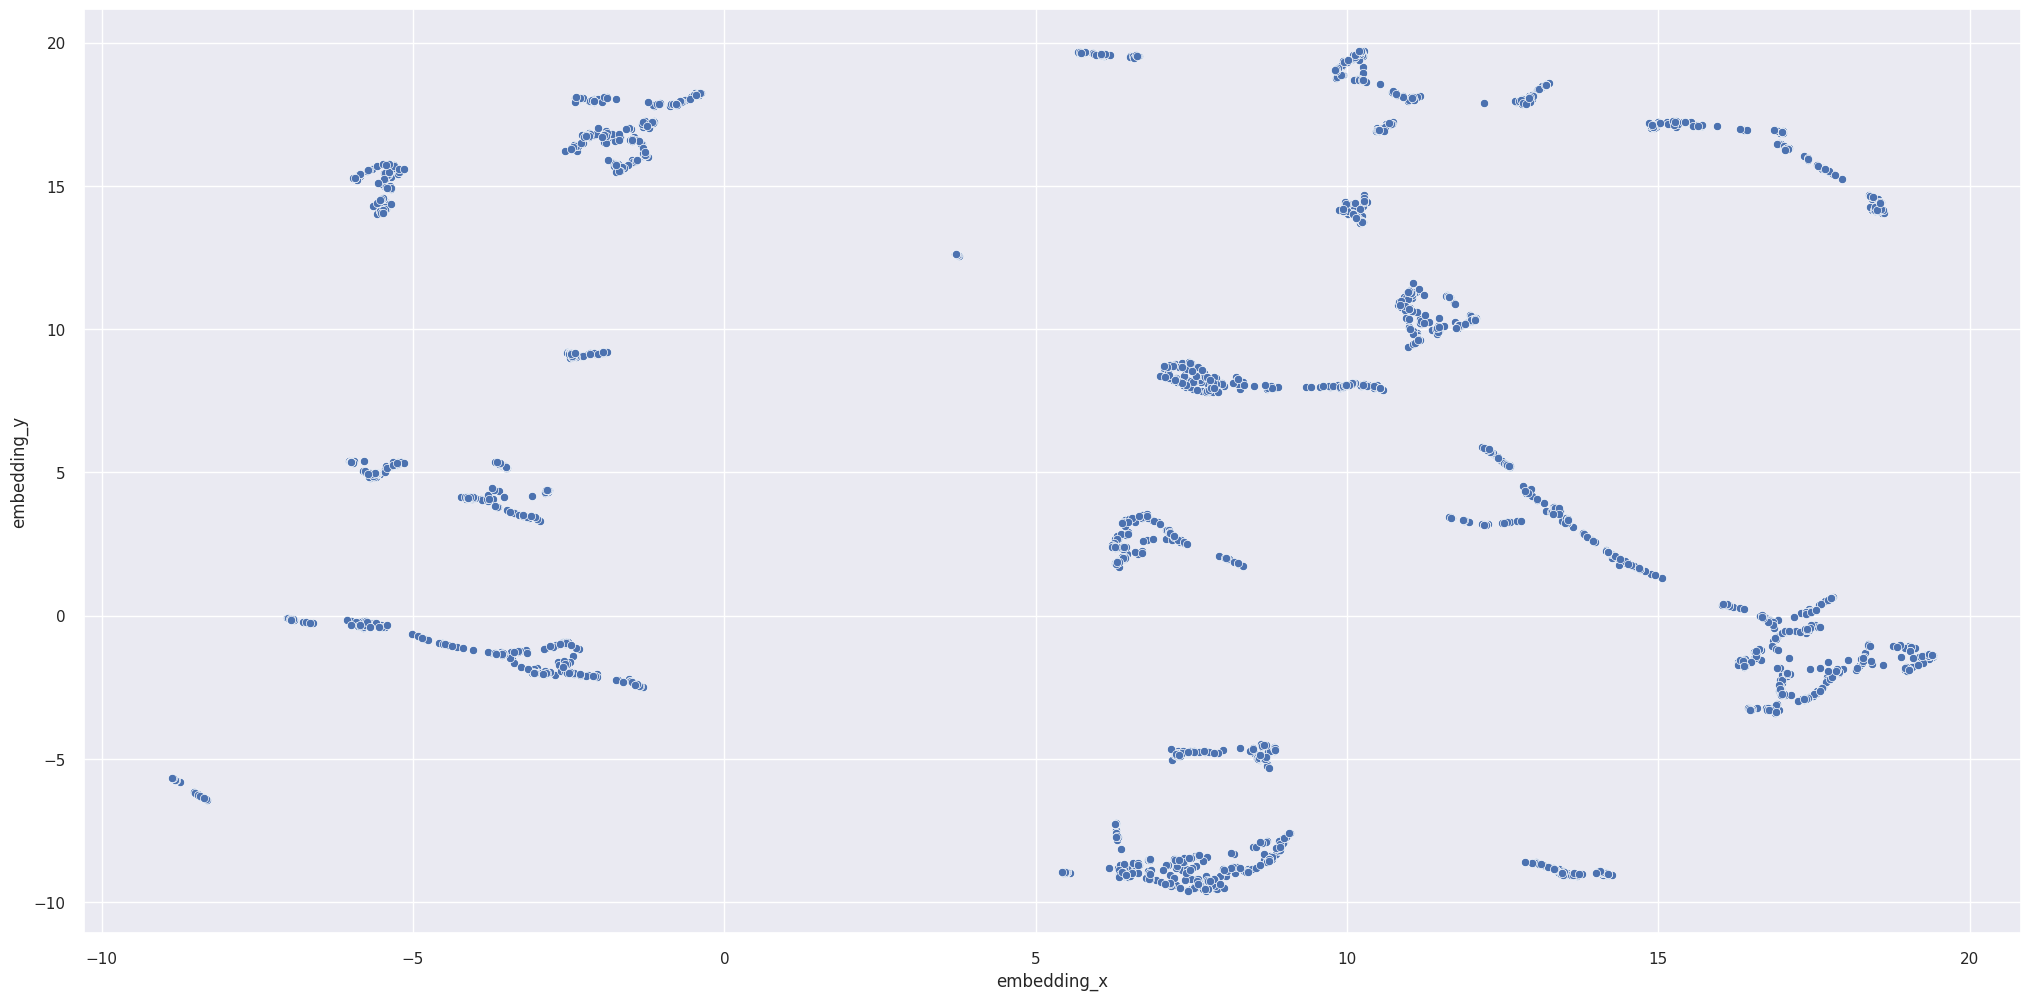

In [321]:
#@title { vertical-output: true}
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

#embedding
#df_pca['embedding_x'] = embedding[:, 0]
#df_pca['embedding_y'] = embedding[:, 1]

df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#Plot
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

#   6.0 FEATURE SELECTION

In [322]:
columns = ['avg_recency_days', 'total_products', 'total_purchases',
          'unique_basket_size', 'avg_ticket']

In [323]:
#df6 = df5.drop(columns=columns, axis=1).copy()

In [324]:
df6 = df_tree.copy()

In [325]:
df6.head()

,embedding_x,embedding_y
0,-2.072018,9.124589
1,-1.476068,15.918642
2,-4.517690,-0.976773
3,12.256502,3.190775
4,5.450171,-8.968206


# 7.0 HYPERPARAMETER FINE-TUNNING





In [326]:
df7 = df6.copy()

In [327]:
X = df7.copy()

In [328]:
X.head()

,embedding_x,embedding_y
0,-2.072018,9.124589
1,-1.476068,15.918642
2,-4.517690,-0.976773
3,12.256502,3.190775
4,5.450171,-8.968206


In [351]:
clusters = np.arange(2, 21, 1)

##  7.1 KMeans

### 7.1.1 Metrics Analysis

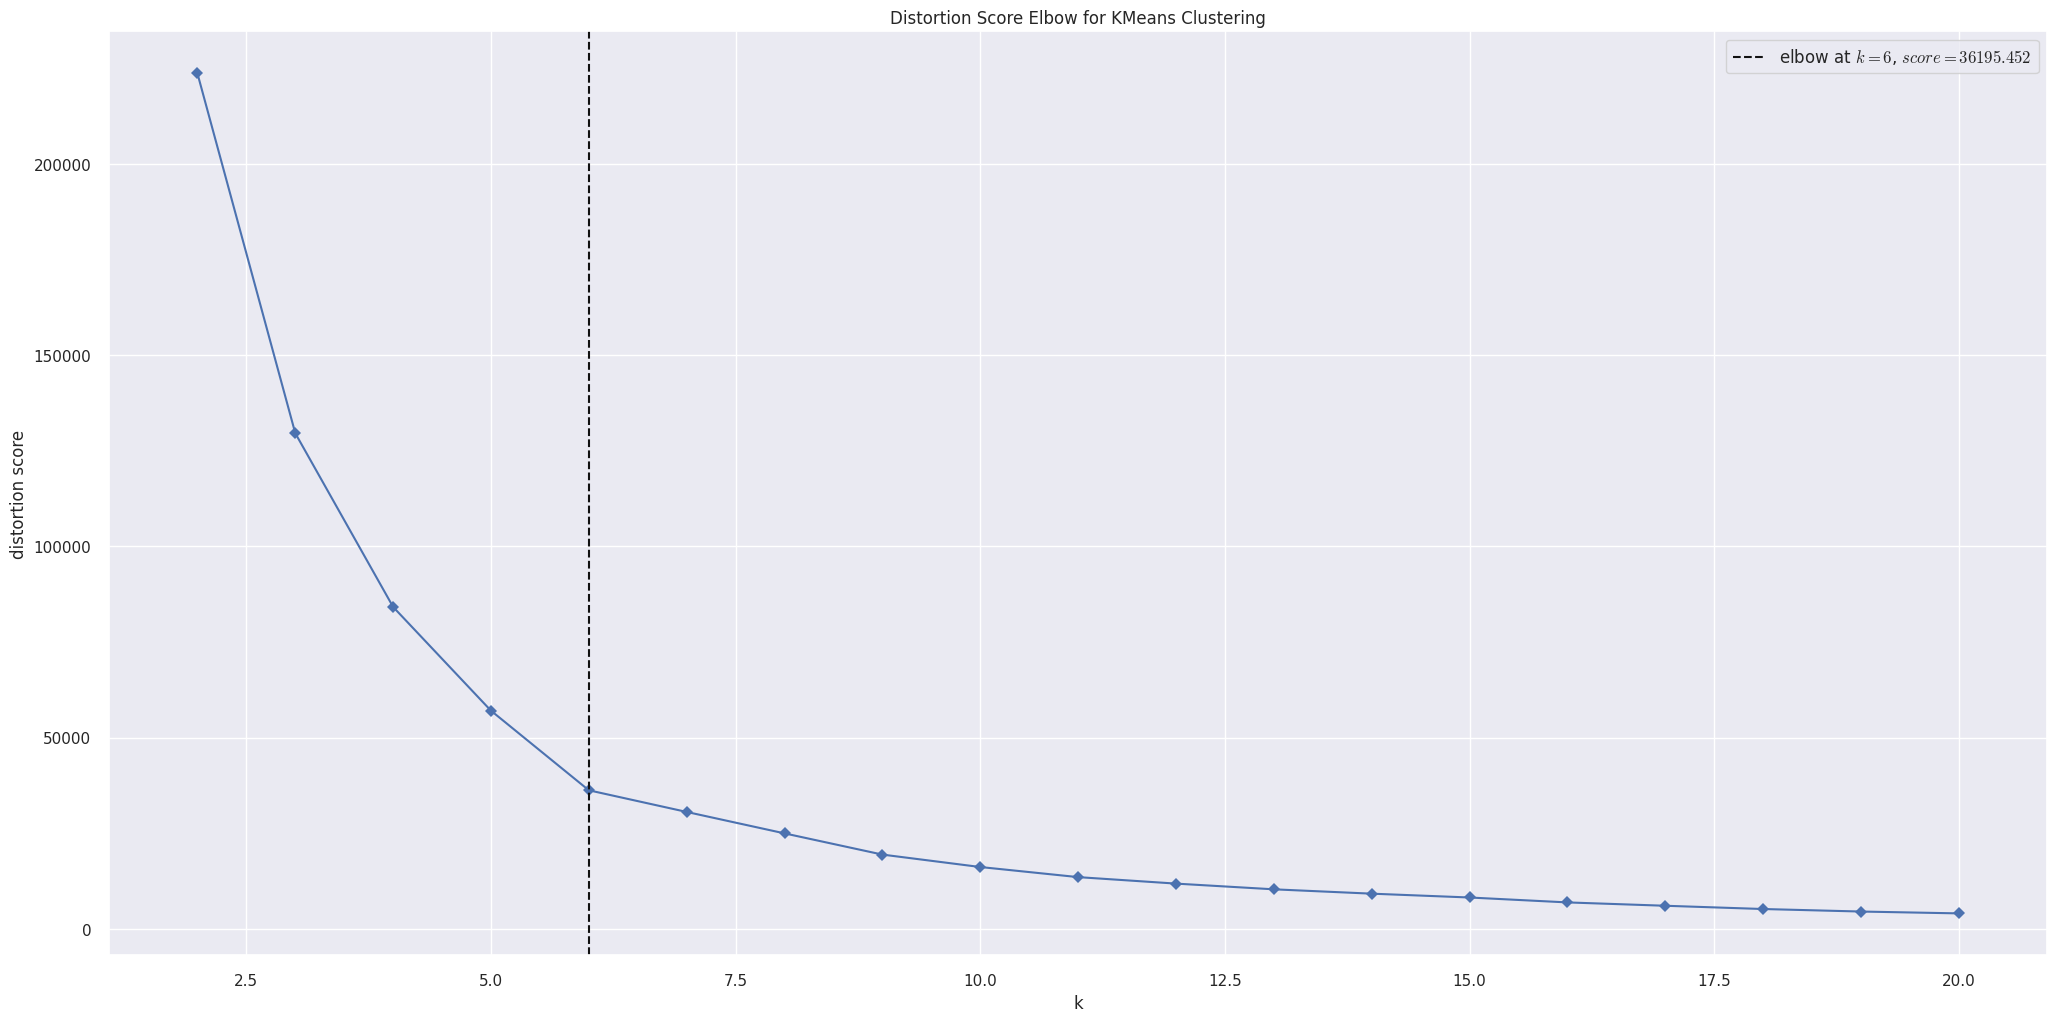

In [352]:
#@title { vertical-output: true}

#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='distortion',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Elbow Method - WSS (Within-Cluster Sum of Squares)
kmeans_model.show();


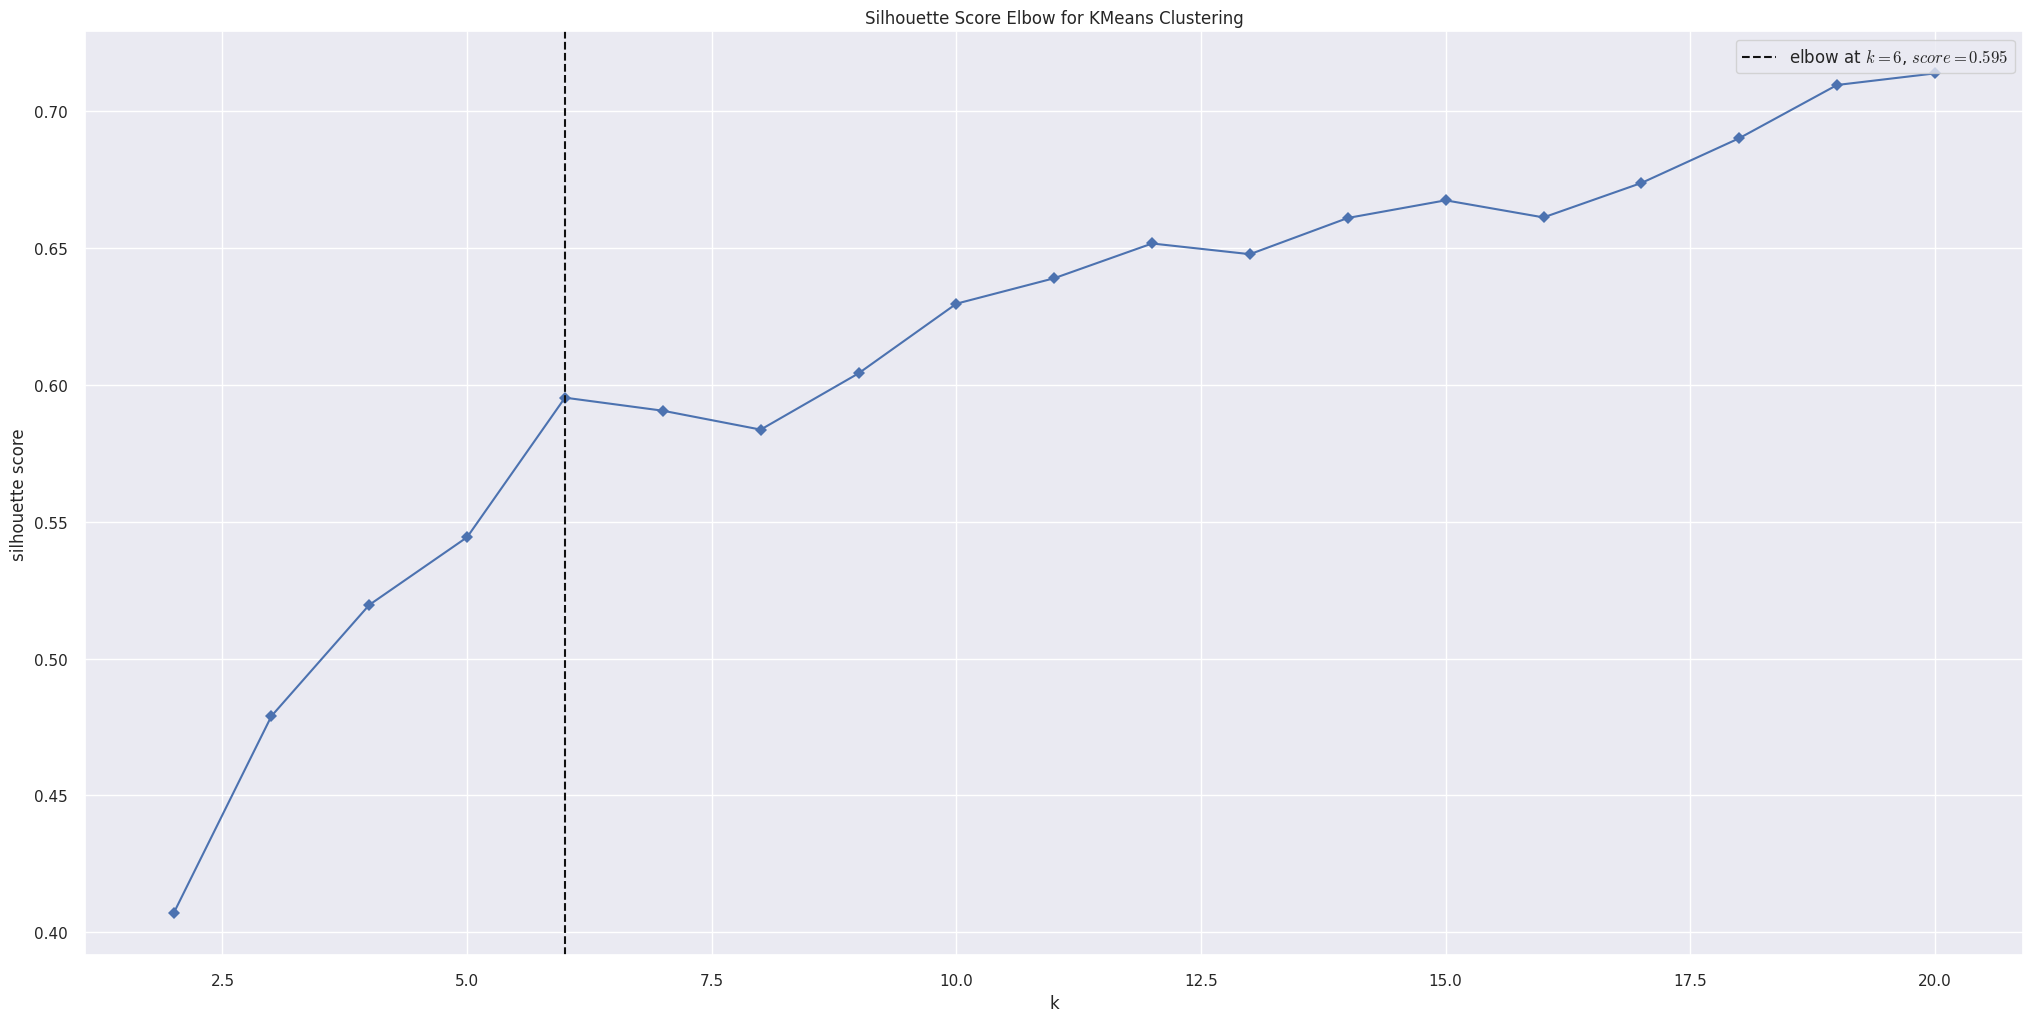

In [353]:
#@title { vertical-output: true}
#Model Define
kmeans_model = KElbowVisualizer(KMeans(), k=clusters, init='random',
                                n_init=10, random_state=42, metric='silhouette',
                                timings=False)

#Model Training
kmeans_model.fit(X)

#Silhouette Score - (Metric value for each cluster)
kmeans_model.show();

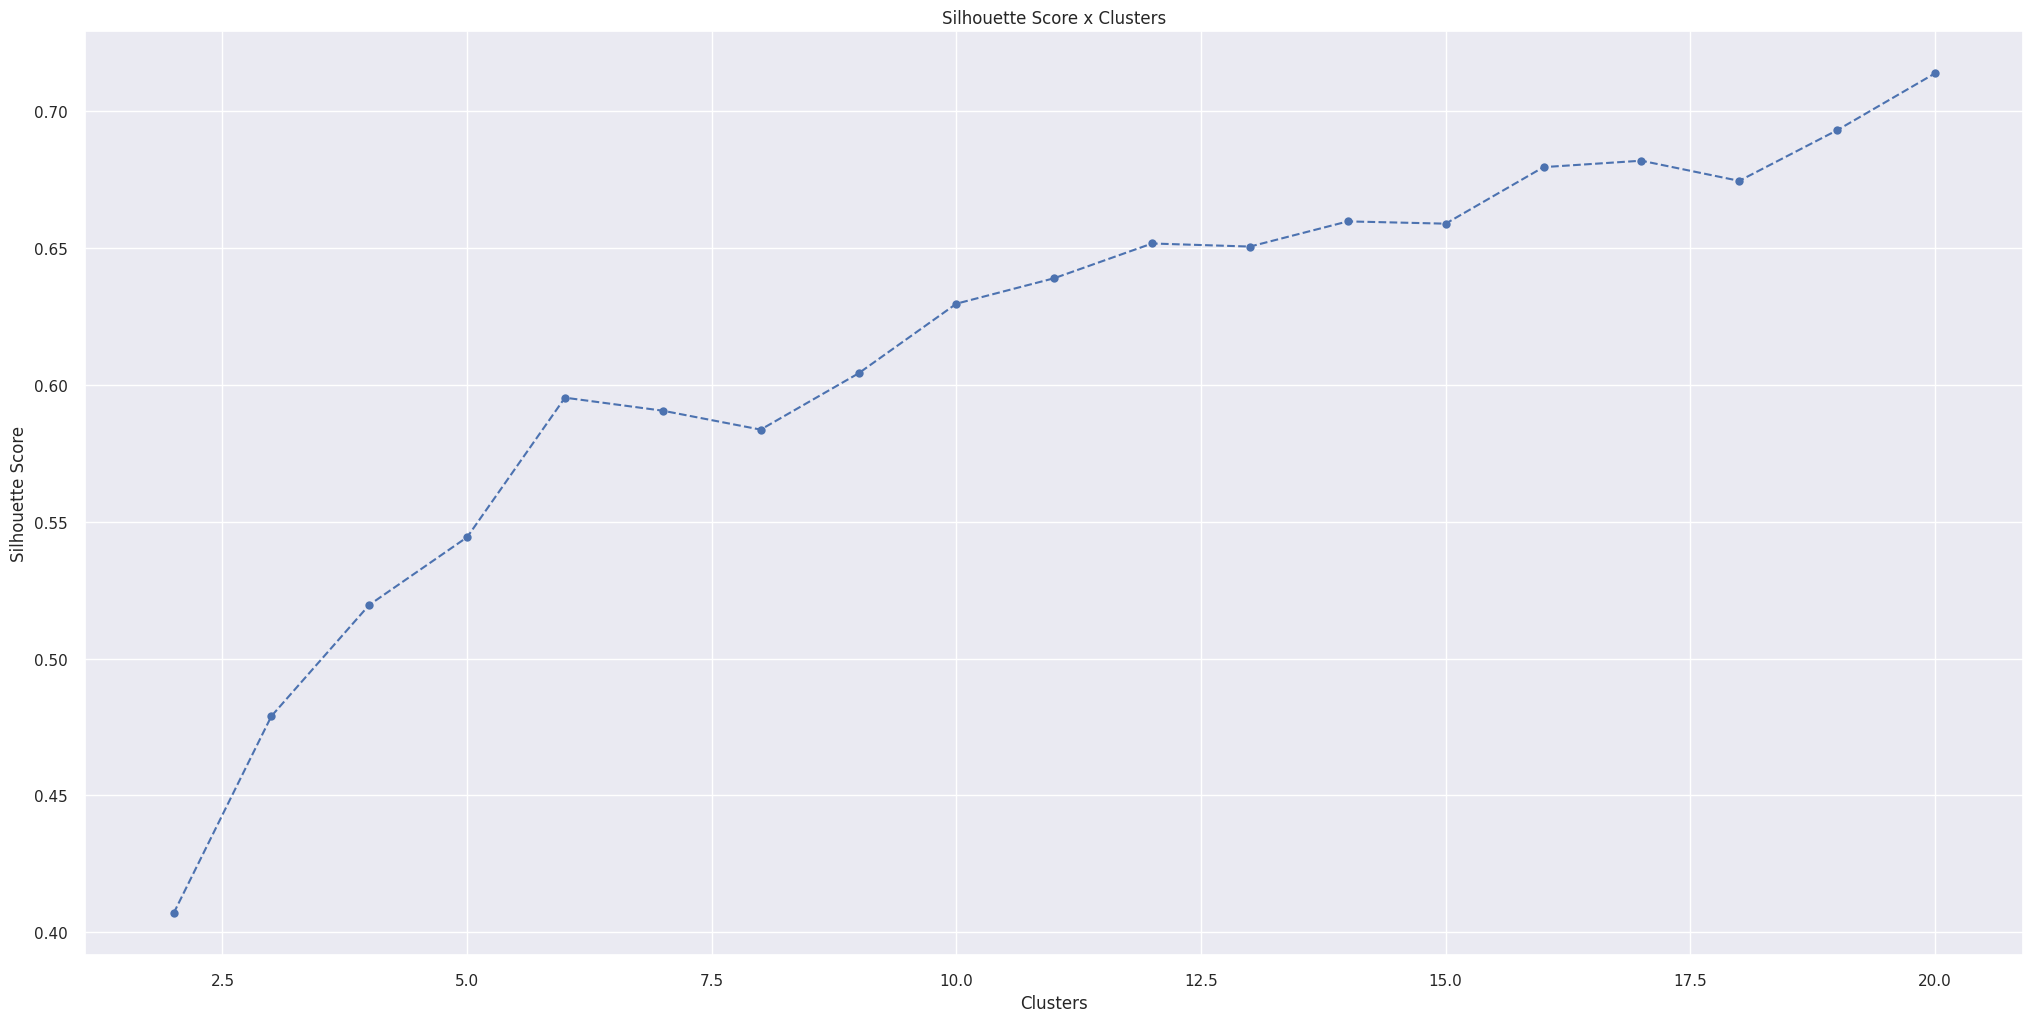

In [354]:
#@title { vertical-output: true}
kmeans_ss = []
for k in clusters:
    #Model Define
    kmeans_model = KMeans(n_clusters = k, random_state=42)

    #Model Training
    kmeans_model.fit(X)

    #Labeling
    kmeans_labels = kmeans_model.predict(X)

    #Performance(Silhouette Score)
    kmeans_score = silhouette_score(X, kmeans_labels, metric='euclidean')
    kmeans_ss.append(kmeans_score)

plt.plot(clusters, kmeans_ss, linestyle='--', marker='o');
plt.title('Silhouette Score x Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters');

## 7.2 GMM (Gaussian Mixture Model)

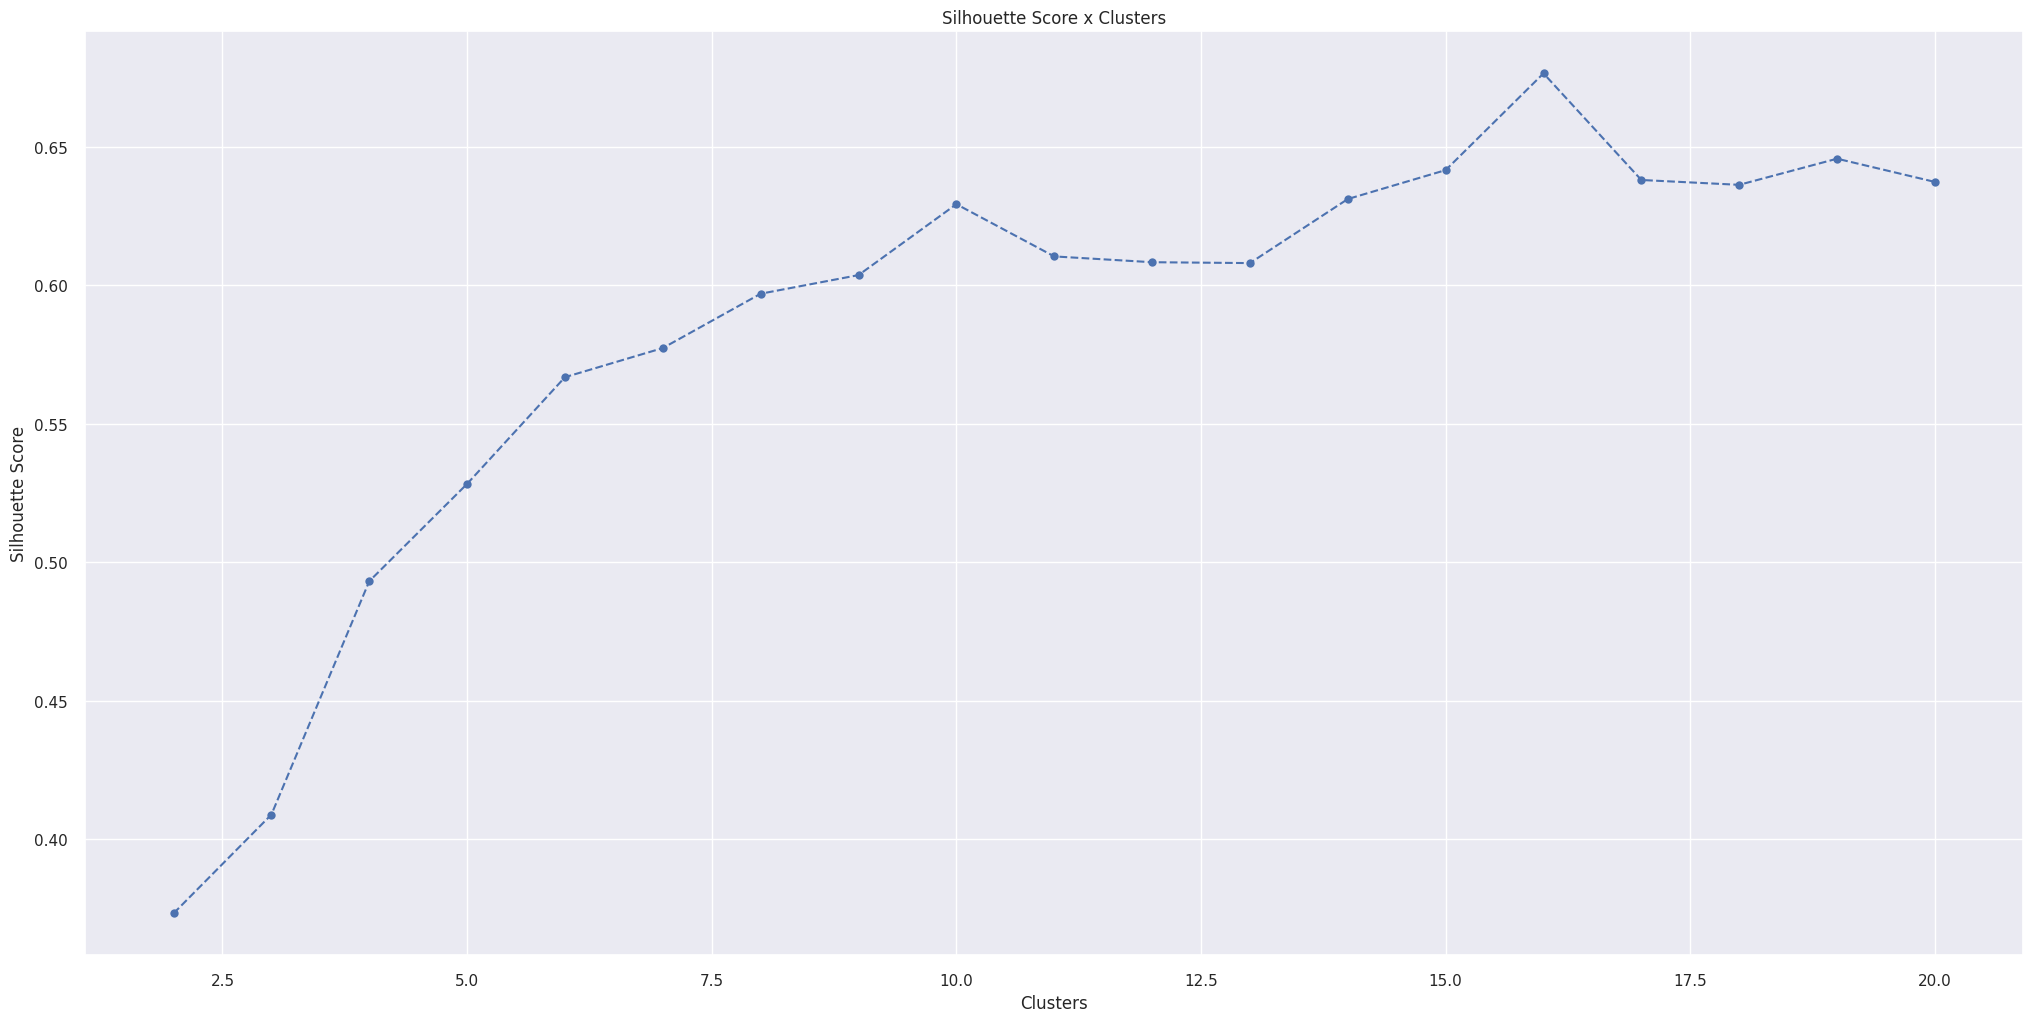

In [355]:
#@title { vertical-output: true}

gmm_ss = []
for k in clusters:
    #Model Define
    gmm_model = GaussianMixture(n_components = k, random_state=42)

    #Model Training
    gmm_model.fit(X)

    #Labeling
    gmm_labels = gmm_model.predict(X)

    #Performance(Silhouette Score)
    gmm_score = silhouette_score(X, gmm_labels, metric='euclidean')
    gmm_ss.append(gmm_score)

plt.plot(clusters, gmm_ss, linestyle='--', marker='o');
plt.title('Silhouette Score x Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters');

## 7.3 Hierarquical Model

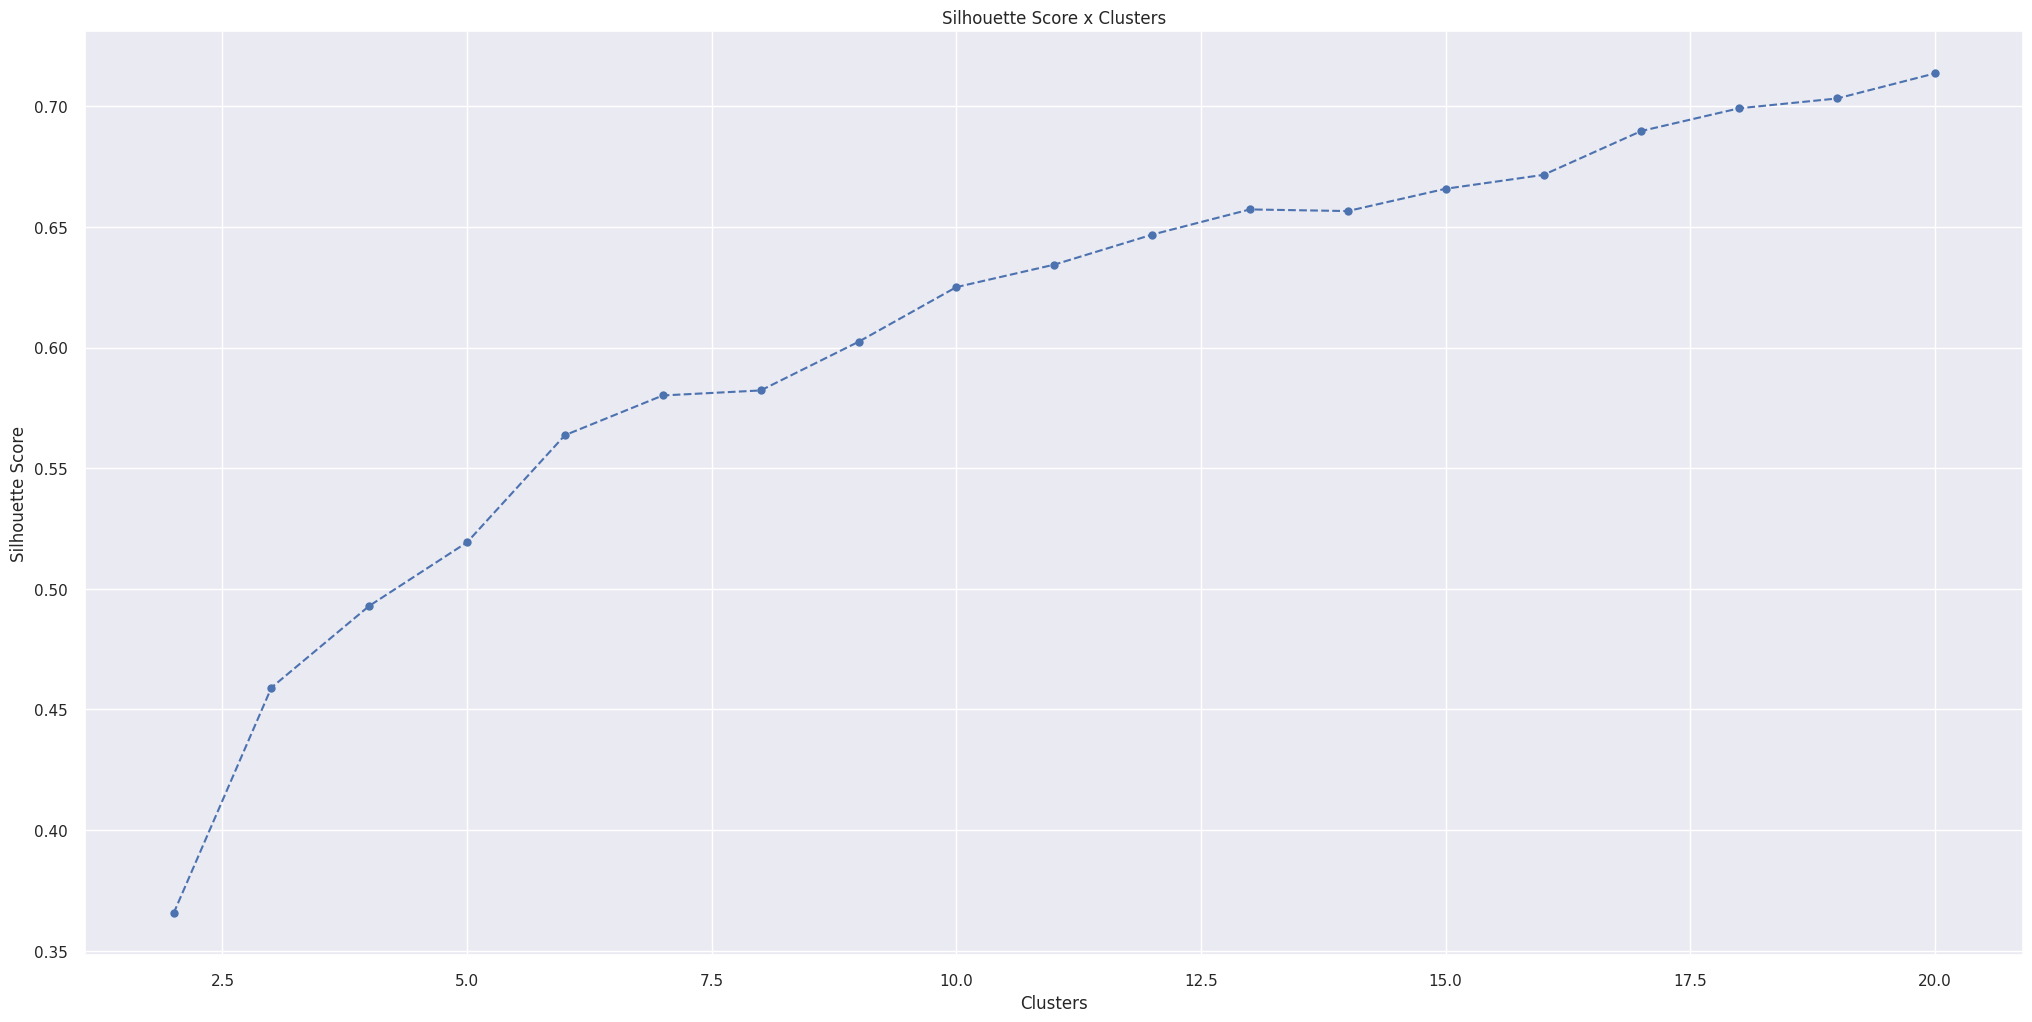

In [356]:
#@title { vertical-output: true}

h_ss = []
for k in clusters:
    #Model Define and Training
    Z = linkage(X, method='ward')

    #Model Predict
    h_labels = fcluster(Z, t=k, criterion='maxclust')

    #Scoring
    h_score = silhouette_score(X, h_labels, metric='euclidean')
    h_ss.append(h_score)

plt.plot(clusters, h_ss, linestyle='--', marker='o');
plt.title('Silhouette Score x Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters');


## 7.4 Density Based Scan (DBSCAN)

In [335]:
eps = 0.05
min_samples = 20
#Model Define & Training
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

#Model Predict
dbscan_labels = dbscan_model.fit_predict(X)

#Model Performance (Scoring)
dbscan_score = silhouette_score(X, dbscan_labels, metric='euclidean')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
unique(dbscan_labels)

In [ ]:
dbscan_score

In [ ]:
#@title { vertical-output: true}

neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances);

In [ ]:
plt.plot(distances[2000:]);

In [ ]:
dbscan_ss = [0.000000, dbscan_score, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Silhouette Score Comparison

In [360]:
df_ss = pd.DataFrame({'KMeans': kmeans_ss,
                      'GMM': gmm_ss,
                      'Hierarquical': h_ss
                      #'DBSCAN': dbscan_ss}
                      }).T
df_ss.columns = clusters

In [361]:
df_ss.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
KMeans,0.406930,0.478993,0.519623,0.544353,0.595332,0.590568,0.583661,0.604212,0.629662,0.638969,0.651657,0.650530,0.659729,0.658901,0.679552,0.681897,0.674534,0.693019,0.713797
GMM,0.373101,0.408798,0.493126,0.528299,0.566857,0.577378,0.597013,0.603741,0.629366,0.610491,0.608399,0.608081,0.631227,0.641679,0.676627,0.638107,0.636357,0.645803,0.637406
Hierarquical,0.365484,0.459060,0.492924,0.519288,0.563680,0.580142,0.582215,0.602377,0.625043,0.634351,0.646786,0.657238,0.656563,0.665805,0.671568,0.689749,0.699161,0.703218,0.713620


### 7.6 Silhouette Analysis

### 7.6.1 K-Means Silhouette

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))


for i in clusters:
    #Model Define
    kmeans = KMeans( n_clusters = i, init='random', n_init=10,
                     max_iter=300, random_state=42)
    q, mod = divmod(i, 2)

    kmeans_model = SilhouetteVisualizer(kmeans, metric='silhouette',
                                        collors='yellowbrick', timings=False,
                                        ax=ax[q-1][mod])

    #Model Training
    kmeans_model.fit(X)

    #Silhouette Score - Silhouette Distribution Visualizer for each cluster
    kmeans_model.finalize();

### 7.6.2 GMM Silhouette

### 7.6.3 Hierarquical Clustering Silhouette

For K = 2; Silhouette Score: 0.3654840588569641
For K = 3; Silhouette Score: 0.45906010270118713
For K = 4; Silhouette Score: 0.49292388558387756
For K = 5; Silhouette Score: 0.5192883014678955
For K = 6; Silhouette Score: 0.5636804699897766
For K = 7; Silhouette Score: 0.5801421403884888


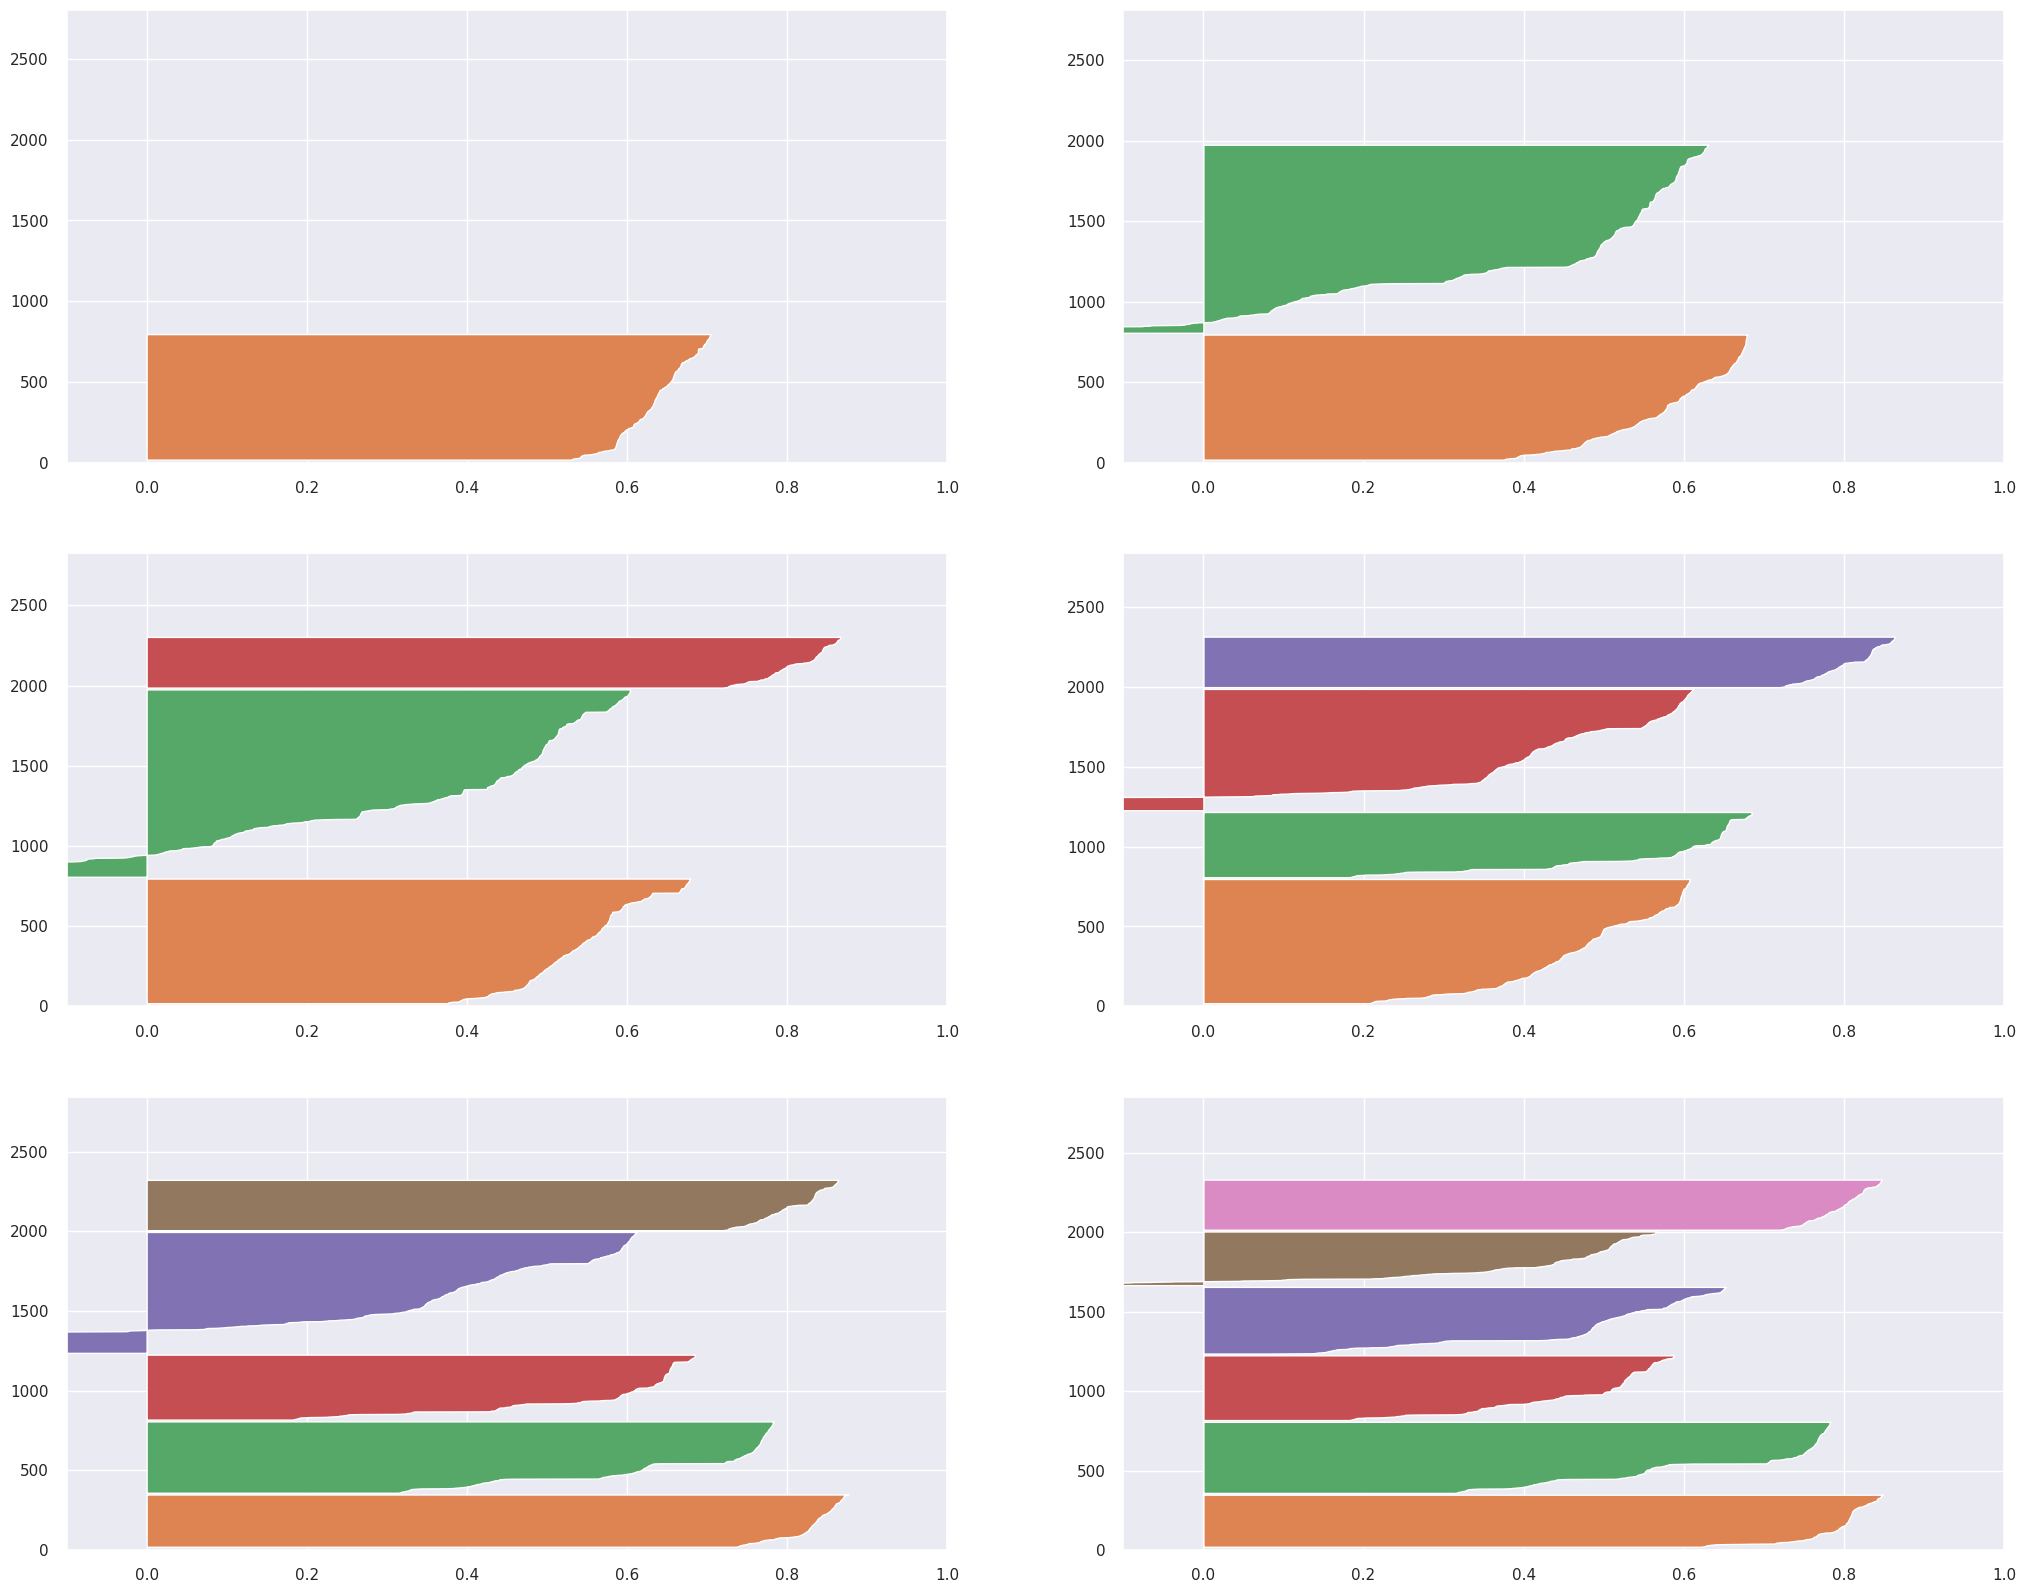

In [338]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(X) + (k+1)*10] )

    #model Define & Training
    Z = linkage(X, 'ward')

    #Model predict
    h_labels = fcluster(Z, t=k, criterion='maxclust')

    #Model performance
    h_score = silhouette_score(X, h_labels, metric='euclidean')
    print(f'For K = {k}; Silhouette Score: {h_score}')

    samples_silhouette_values = silhouette_samples(X, h_labels)

    y_lower = 10
    for i in range(k):
        ith_samples_silhouette_values = samples_silhouette_values[h_labels == i]
        ith_samples_silhouette_values.sort()

        #size_cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #Coloring
        cmap = plt.get_cmap('Spectral')
        color = cmap( i/k )


        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        y_lower = y_upper + 10

### 7.6.4 DBSCAN Silhouette

# 8.0 MODEL TRAINING

In [362]:
k = 10

#Model definition
kmeans_model = KMeans(n_clusters=k, init='random', random_state=42, n_init=10, max_iter=300)

#Model Training
kmeans_model.fit(X)

#Labeling
labels = kmeans_model.labels_

In [363]:
#WSS (Within-Cluster Sum of Square)
print(f'WSS value: {kmeans_model.inertia_}')

#SS (Silhouette Score)
print(f'Silhouette Score: {silhouette_score(X, labels)}')

WSS value: 17562.376953125
Silhouette Score: 0.6044027209281921


# 9.0 CLUSTER ANALYSIS

In [364]:
df9 = df4.drop(columns=columns, axis=1)

## 9.1  Visualization Inspection

In [365]:
df9['cluster'] = labels
df9.head()

,customer_id,revenue,recency,distinct_stock_code,basket_size,frequency,returned,cluster
0,17850,5391.21,372.0,21.0,50.970588,17.000000,40.0,4
1,13047,3232.59,56.0,105.0,154.444444,0.028302,35.0,2
2,12583,6705.38,2.0,114.0,335.200000,0.040323,50.0,7
3,13748,948.25,95.0,24.0,87.800000,0.017921,0.0,1
4,15100,876.00,333.0,1.0,26.666667,0.073171,22.0,3


In [ ]:
#fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
#fig.show()

In [ ]:
#df_viz = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_viz, hue='cluster')

In [366]:
df_viz = df9.copy()

### 9.2 High Dimensionality Analysis (Topological Analysis - UMAP)

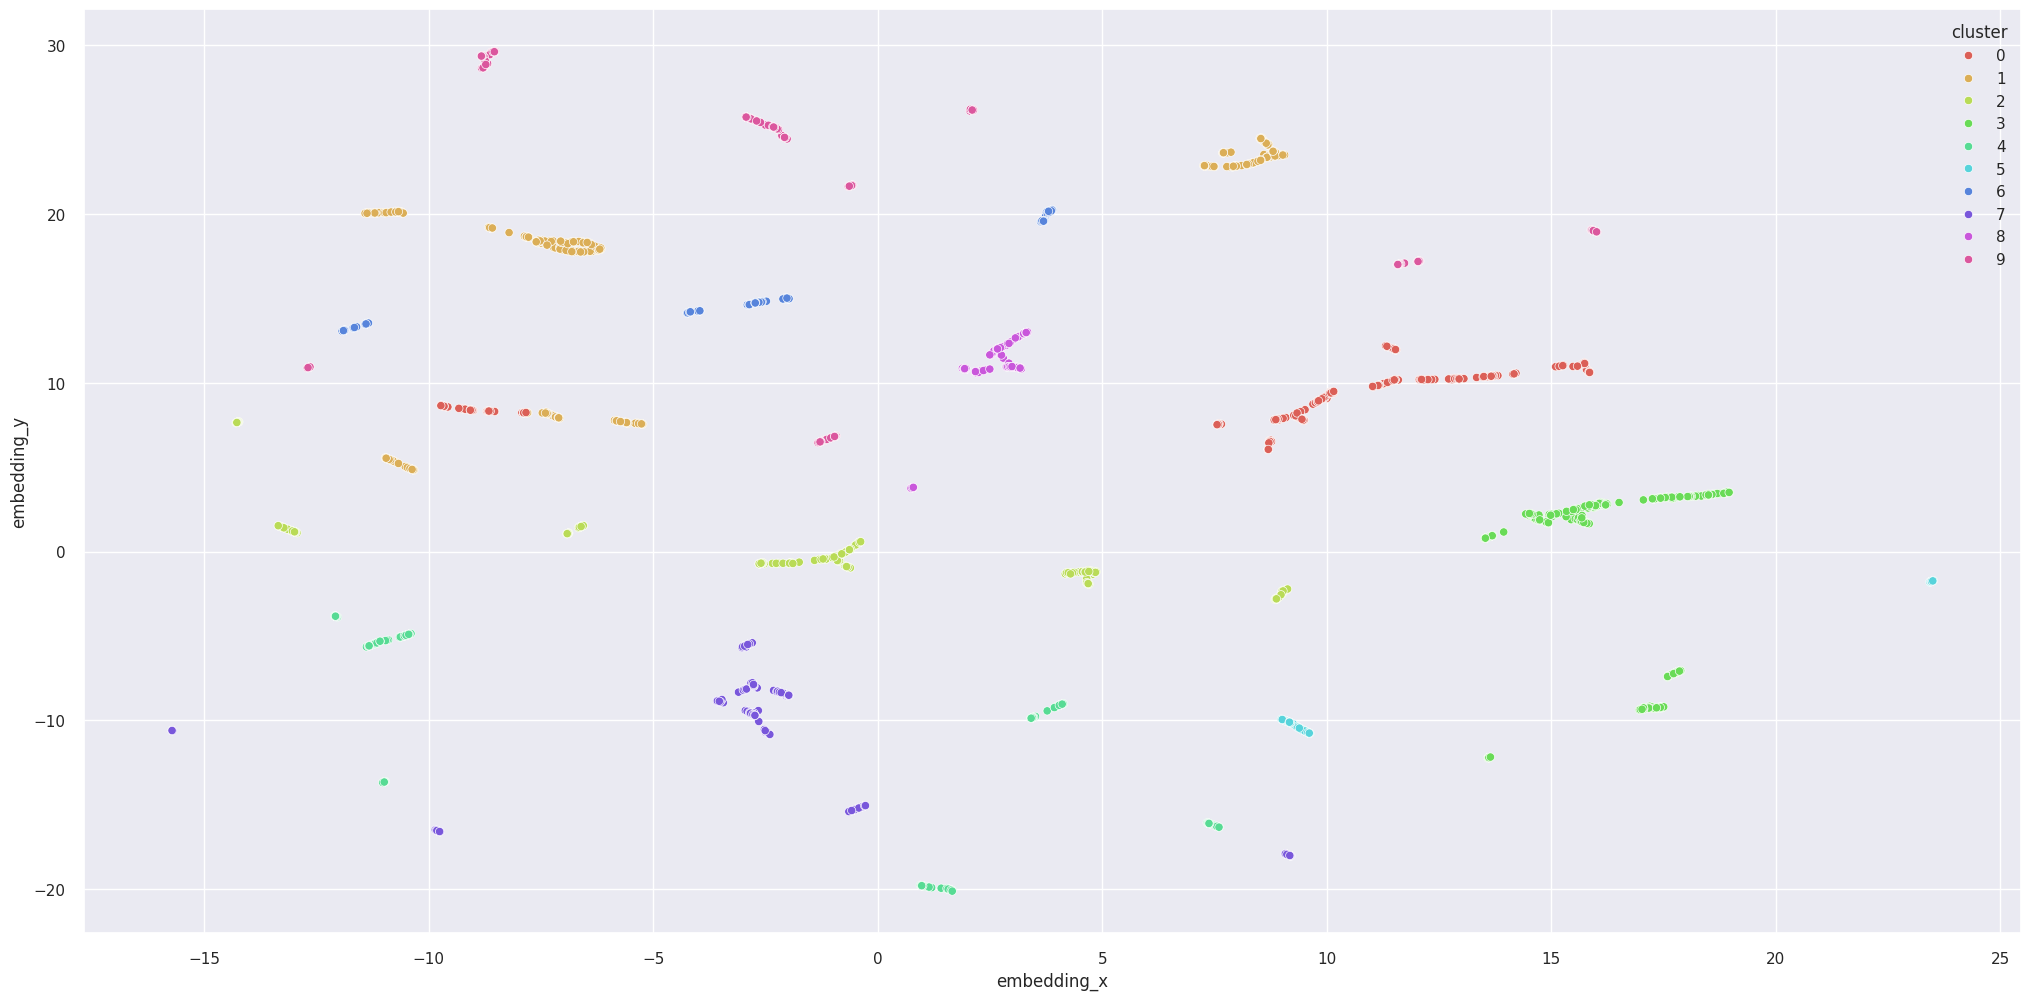

In [367]:
reducer = umap.UMAP(random_state=42, n_neighbors=100)
embedding = reducer.fit_transform(X)

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

sns.scatterplot(x= 'embedding_x', y= 'embedding_y',
                hue='cluster',
                palette= sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## 9.2 Cluster Profile

In [370]:
#Number of Customers
df_customer = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_customer = df_customer.rename(columns={'customer_id': 'total_customers'})
df_customer['perc_customers'] = 100*(df_customer['total_customers']/df_customer['total_customers'].sum())

#Avg Revenue
df_revenue = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_revenue = df_revenue.rename(columns={'revenue': 'avg_revenue'})

#Avg Frequency
df_frequency = df9[['cluster', 'frequency']].groupby('cluster').mean().reset_index()
df_frequency = df_frequency.rename(columns={'frequency': 'avg_frequency'})

#Avg Recency
df_recency = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_recency = df_recency.rename(columns={'recency': 'avg_recency'})

#Avg Distinct Products
df_stock_code = df9[['cluster', 'distinct_stock_code']].groupby('cluster').mean().reset_index()
df_stock_code = df_stock_code.rename(columns={'distinct_stock_code': 'avg_distinct_products'})

#Avg Basket Size
df_basket_size = df9[['cluster', 'basket_size']].groupby('cluster').mean().reset_index()
df_basket_size = df_basket_size.rename(columns={'basket_size': 'avg_basket_size'})

#Avg Returned Products
df_returned = df9[['cluster', 'returned']].groupby('cluster').mean().reset_index()
df_returned = df_returned.rename(columns={'returned': 'avg_returned_products'})


df_profile = pd.merge(df_customer, df_revenue, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_frequency, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_recency, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_stock_code, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_basket_size, how='left', on='cluster')
df_profile = pd.merge(df_profile, df_returned, how='left', on='cluster')

df_profile.sort_values('avg_revenue', ascending=False)

,cluster,total_customers,perc_customers,avg_revenue,avg_frequency,avg_recency,avg_distinct_products,avg_basket_size,avg_returned_products
7,7,287,10.349802,15257.986690,0.075166,20.174216,198.310105,557.262407,228.351916
4,4,222,8.005770,3828.037838,0.114154,27.045045,149.545045,311.013637,35.563063
2,2,336,12.116841,2476.822530,0.030018,40.511905,107.333333,313.990208,21.255952
9,9,299,10.782546,1760.663378,0.032254,44.317726,83.652174,269.060720,17.705686
6,6,175,6.310855,1566.355200,0.029598,35.640000,84.845714,114.410423,17.154286
1,1,462,16.660656,1057.615758,0.040005,60.880952,61.716450,217.608533,9.636364
8,8,153,5.517490,770.442157,0.043194,76.620915,50.980392,189.753813,6.653595
0,0,390,14.064190,636.133026,0.048032,77.756410,45.469231,119.808696,3.400000
5,5,89,3.209520,496.442584,0.030671,82.393258,34.853933,94.629869,5.303371
3,3,360,12.982330,357.287194,0.054052,96.344444,21.800000,57.655096,2.344444


In [372]:
10.34 + 8 + 12.11 + 10.78+ 6.31

47.54

## 9.3 Descrição dos Clusters

### 9.3.1 Espaço de Dados: Features

## Cluster 00: (Candidato à Insider)

*   Número de Customers = 1784 (64.33% da base de dados)
*   Recência Média = 18 dias
*   Compras em Média = 239 produtos por cliente (Basket Size)
*   Receita Média = $3741,95 por cliente

## Cluster 02: (Estudo de Viabilidade ao programa Insider)

*   Número de Customers = 674 (24.30% da base de dados)
*   Recência Média = 85 dias
*   Compras em Média =  233 produtos por cliente (Basket Size)
*   Receita Média = $1337,46 por cliente

## Cluster 01: (Não Selecionados)

*   Número de Customers = 315 (11.36% da base de dados)
*   Recência Média = 216 dias
*   Compras em Média = 5 compras
*   Receita Média = $990,28 por cliente



### 9.3.2 Espaço de Dados (Embedding: Arvóre de Decisão)

*   O espaço de Embedding pode ser utilizado caso exista a necessidade da obtenção de um número maior de clusters, viabilizada por uma maior separação quando em comparação ao espaço de features.
*   O Trade off, no entanto, é que perde-se a explicabilidade da correlação entra as features aplicadas ao modelo.

## Clusters Selectionados (7, 4, 2, 9 e 6)

*   Número de Customers = 1319 Clientes (47.54% da base de dados)
*   Recência Média < 45 Dias
*   Compras em Média ~Aprox 200 produtos por cliente (Basket Size)
*   Receita Média > $1500 por Cliente


#   10.0 DEPLOY TO PRODUCTION